# Combine IDOC population data sets

IDOC publishes population data sets which consist of each person housed in a state prison each quarter and information about them, such as their demographics, the type of crime they're being held for, the date on which they were apprehended, etc. The data sets are .xls files, but the titles, URLs, and data within each data set differ and need to be cleaned. This script combines all population data sets and makes the information within them consistent.

The population data sets can be found here: https://www2.illinois.gov/idoc/reportsandstatistics/Pages/Prison-Population-Data-Sets.aspx

This was last updated with the Dec 2021 data set as the most recently published data set.

In [1]:
# import packages and set up
from bs4 import BeautifulSoup
parser = 'html.parser'
import urllib.request

import pandas as pd
import numpy as np
from datetime import datetime as dt, date, timedelta as td, time
import calendar

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
inline_rc = dict(mpl.rcParams)
import plotly.graph_objects as go

import warnings


# suppress warnings
pd.options.mode.chained_assignment = None



In [2]:
# helper function to get list of hex codes from tableau 20 pallette
from pylab import *

def get_hex(n):
    cmap = cm.get_cmap('tab20', n)
    hex_list = []
    for i in range(cmap.N):
        rgb = cmap(i)[:3]  # will return rgba, we take only first 3 so we get rgb
        hex_list.append(matplotlib.colors.rgb2hex(rgb))
        
    return hex_list


# helper function to get rgb code from hex code
def get_rgb_from_hex(hex_code):
    h = hex_code.lstrip('#')
    rgb = tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
    return rgb

Get links to the population data sets from the IDOC site.

In [3]:
resp = urllib.request.urlopen('https://www2.illinois.gov/idoc/reportsandstatistics/Pages/Prison-Population-Data-Sets.aspx')
soup = BeautifulSoup(resp, parser, from_encoding=resp.info().get_param('charset'))

link_list = []
for link in soup.find_all('a', href=True):
    if '.xls' in link['href']:
        link_list.append('https://www2.illinois.gov' + link['href'])
# print(link_list)



Read in and combine the data sets. This takes a bit.

In [6]:
# add each doc date to the df - different url formats need to be read
df_list = []
cnt = 0

for link in link_list:
    cnt += 1
    print(str(cnt) + ' of ' + str(len(link_list)) + ' - ' + link)
    
    # read in the spreadsheet
    df = pd.read_excel(link, dtype=object, skiprows=5)
    
    # only one format like this
    if link == 'https://www2.illinois.gov/idoc/reportsandstatistics/Documents/2nd%20September%202021%20Prison%20Stock.xls':
        doc_month_number = 9
        doc_year = 2021
        doc_day = 30
        
    elif link == 'https://www2.illinois.gov/idoc/reportsandstatistics/Documents/Dec%2031%202019%20Prison%20Stock%20pop.xls':
        doc_month_number = 12
        doc_year = 2019
        doc_day = 31
    
    else:
        # format like https://www2.illinois.gov/idoc/reportsandstatistics/Documents/March%202021%20%20Prison%20Stock.xls
        try:
            doc_month_name = link.split(r'Documents/')[1].split(r'%20')[0]
            doc_month_name = doc_month_name[:3]
            doc_month_number = dt.strptime(doc_month_name, "%b").month
            doc_year = int(link.split(r'Documents/')[1].split(r'%20')[1][:4])
            doc_day = calendar.monthrange(doc_year, doc_month_number)[1]

        # format like https://www2.illinois.gov/idoc/reportsandstatistics/Documents/Internet%20Data%20Set%20Prison_Stock_Dec_2017.xls
        except:
            try:
                doc_month_name = link.split('_')[2]
                doc_month_name = doc_month_name[:3]
                doc_month_number = dt.strptime(doc_month_name, "%b").month
                try:
                    doc_year = int(link.split('_')[3][:4])
                # _Jun%202017
                except:
                    doc_year = int(link.split('_')[2].split('%20')[1][:4])
                doc_day = calendar.monthrange(doc_year, doc_month_number)[1]

            # format like https://www2.illinois.gov/idoc/reportsandstatistics/Documents/Prison%20Population%206-30-16%20Data%20Set.xls
            except:
                doc_month_number = int(link.split('-')[0].split('%20')[2])
                doc_year = int('20' + link.split('-')[2].split('%20')[0])
                doc_day = calendar.monthrange(doc_year, doc_month_number)[1]
#                 print(date(doc_year, doc_month_number, doc_day))

    # create the doc date
    df['Doc Date'] = date(doc_year, doc_month_number, doc_day)

    # add the df to the list
    df_list.append(df)
    
# combine the dfs
df = pd.concat(df_list)

    

1 of 44 - https://www2.illinois.gov/idoc/reportsandstatistics/Documents/September%202022%20Prison%20Population.xls
2 of 44 - https://www2.illinois.gov/idoc/reportsandstatistics/Documents/June%202022%20Prison%20Population.xls
3 of 44 - https://www2.illinois.gov/idoc/reportsandstatistics/Documents/March%202022%20Prison%20Stock.xls
4 of 44 - https://www2.illinois.gov/idoc/reportsandstatistics/Documents/December%202021%20Prison%20Stock.xls
5 of 44 - https://www2.illinois.gov/idoc/reportsandstatistics/Documents/2nd%20September%202021%20Prison%20Stock.xls
6 of 44 - https://www2.illinois.gov/idoc/reportsandstatistics/Documents/June%202021%20Prison%20Stock.xls
7 of 44 - https://www2.illinois.gov/idoc/reportsandstatistics/Documents/March%202021%20%20Prison%20Stock.xls
8 of 44 - https://www2.illinois.gov/idoc/reportsandstatistics/Documents/Dec%202020%20%20Prison%20Stock.xls
9 of 44 - https://www2.illinois.gov/idoc/reportsandstatistics/Documents/Sept%202020%20Prison%20Pop.xls
10 of 44 - https://w

Export file so I don't have to read these in every time.

In [ ]:
# df.to_csv('raw_full_pop_data.csv')

# df = pd.read_csv('raw_full_pop_data.csv', dtype=object)


Remove notes at the end of each doc

In [7]:
df = df[~pd.isnull(df['Name'])]
df.reset_index(inplace=True)
df['Idx'] = df.index


**Explore the data**

In [8]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800407 entries, 0 to 1800406
Data columns (total 34 columns):
 #   Column                                              Dtype         
---  ------                                              -----         
 0   index                                               int64         
 1   Unnamed: 0                                          object        
 2   IDOC #                                              object        
 3   Name                                                object        
 4   Date of Birth                                       object        
 5   Sex                                                 object        
 6   Race                                                object        
 7   Veteran Status                                      object        
 8   Current Admission Date                              object        
 9   Admission Type                                      object        
 10  Parent Institution

**Dedupe/combine columns**

Sometimes, columns in the individual data sets had different names. Combine these into a single column in the combined version.


In [9]:
# rename dupe columns so they can be consolidated programmatically
df.rename(columns={'Projected Discharge  Date2': 'Projected Discharge Date1', 'Current Admission Type': 'Admission Type1'}, inplace=True)
   
len1 = len(df)
dupe_col_name_list = ['Projected Mandatory Supervised Release (MSR) Date', 'Projected Discharge Date', 'Current Admission Date', 'Admission Type']
for col_name in dupe_col_name_list:
    print('\nCombining {c} dupes'.format(c=col_name))
    
    print(df[col_name].notnull().sum())
    
    for dupe_num in range(1, 5):
        if col_name + str(dupe_num) in df.columns:
            
            # replace the blanks in the main column with non-nulls in the dupe
            df[col_name].fillna(df[col_name + str(dupe_num)], inplace=True)
            print(df[col_name].notnull().sum())
            
            # drop the dupe
            df.drop(col_name + str(dupe_num), axis=1, inplace=True)

# remove empty columns
print('\nDropping empty columns:')
for col in df.columns:
    if df[col].isnull().all():
        print('   {c}'.format(c=col))
        df.drop(col, axis=1, inplace=True)
    
print(df.columns)
            
# df1 = df.copy()




Combining Projected Mandatory Supervised Release (MSR) Date dupes
120967
944630
1705154
1744952

Combining Projected Discharge Date dupes
116143
165100
934674
1647409
1687208

Combining Current Admission Date dupes
1760608
1800407

Combining Admission Type dupes
1756899
1800407

Dropping empty columns:
   Unnamed: 0
Index(['index', 'IDOC #', 'Name', 'Date of Birth', 'Sex', 'Race',
       'Veteran Status', 'Current Admission Date', 'Admission Type',
       'Parent Institution',
       'Projected Mandatory Supervised Release (MSR) Date',
       'Projected Discharge Date', 'Custody Date', 'Sentence Date',
       'Crime Class', 'Holding Offense', 'Holding Offense Category',
       'Offense Type', 'Sentence Years', 'Sentence Months',
       'Truth in Sentencing', 'Sentencing County', 'Doc Date', 'Idx'],
      dtype='object')


**Explore further**

Which fields need cleaning?

In [10]:
for col in df.columns:
    print('\n')
    print(df[col].value_counts(dropna=False))
    



0        44
20042    44
15940    44
13893    44
11846    44
         ..
48890     1
48929     1
48889     1
48911     1
48934     1
Name: index, Length: 48957, dtype: int64


R24647    44
K70415    44
A97512    44
R10954    44
K97356    44
          ..
N66128     1
R48039     1
Y52900     1
R12311     1
M02713     1
Name: IDOC #, Length: 235775, dtype: int64


WILLIAMS, MICHAEL    699
SMITH, MICHAEL       562
WILLIAMS, ANTHONY    546
JOHNSON, MICHAEL     539
BROWN, ANTHONY       493
                    ... 
PADILLA, KALIN R.      1
COOKS, BARBARA         1
NEAL, YULONDA C.       1
MAEZ, DANIEL           1
MOORE, CLABE           1
Name: Name, Length: 232162, dtype: int64


1980-04-07 00:00:00    298
1980-08-08 00:00:00    291
1973-09-29 00:00:00    282
1982-07-07 00:00:00    282
1980-07-21 00:00:00    270
                      ... 
2261974                  1
7301936                  1
1951-06-14 00:00:00      1
2002-06-12 00:00:00      1
01021949                 1
Name: Date of Birth,

0006    158399
0003    156161
0004    138086
0005     84201
0002     82210
         ...  
110          1
0522         1
LFE          1
999          1
0210         1
Name: Sentence Years, Length: 242, dtype: int64


00     1377870
0       123262
000      76187
06       65344
         57066
        ...   
069          1
035          1
075          1
052          1
089          1
Name: Sentence Months, Length: 287, dtype: int64


Day-for-Day                    1247698
85%                             249366
100%                            153527
85% Armed Habitual Criminal      21678
0.85                             17972
NaN                              17896
85% Bodily Harm                  17881
85% Agg Domestic Battery         16103
85% Agg Discharge Firearm        15204
75% Drug-Related Offenses        11827
1                                10187
85% Agg DUI w Death               9128
Missing                           4521
85% Agg Arson                     3142
85% Agg DUI w Bodily Ha

* Sex has nulls and incorrect values
* Race has nulls and values that can be combined
* Veteran Status has values that can be combined
* Parent Institution has values that can be combined
* Crime Class has nulls and values that can be combined
* Sentencing County has values that can be combined and should be categorized


* Truth in Sentencing needs % split into its own column


* Sentence Years needs further exploration - includes 0002, 999, LFE
* Sentence Months needs further exploration - do these match Sentence Years?


* Date of Birth has multiple date formats
* Current Admission Date has multiple date formats
* Custody Date has multiple date formats
* Sentence Date has multiple date formats
* Projected Mandatory Supervised Release (MSR) Date has multiple date formats and non-date values
* Projected Discharge Date has multiple date formats and non-date values


* Admission Type needs further exploration
* Holding Offense needs further exploration and should be categorized
    * Holding Offense Category exists, but use Phil's categories as well
    * Offense Type exists, but use Phil's categories as well


**Clean Sex**

Sex contains empty spaces and "B" value.

In [11]:
df.loc[(df['Sex'] == 'B') | (df['Sex'] == ' '), 'Sex'] = 'Unknown'
print(df['Sex'].value_counts())


Male       1696853
Female      103549
Unknown          5
Name: Sex, dtype: int64


**Clean Race**

Race contains empty spaces, Unknown, and Not Assigned.

In [12]:
df.loc[(df['Race'] == 'Not Assigned') | (df['Race'] == ' '), 'Race'] = 'Unknown'
print(df['Race'].value_counts())


Black              1023133
White               539111
Hispanic            227062
Asian                 6126
American Indian       2553
Unknown               1227
Bi-Racial             1195
Name: Race, dtype: int64


**Clean Veteran Status**

Veteran Status contains Yes, No, NaN, and Unknown. 

In [13]:
# check if NaN means No or Unknown
null_vet_status_df = df[df['Doc Date'].isin(df[pd.isnull(df['Veteran Status'])]['Doc Date'])]
print(null_vet_status_df['Veteran Status'].value_counts(dropna=False))

# plenty of Nos in the same documents as the NaNs, so NaN likely means "Unknown"
df.loc[pd.isnull(df['Veteran Status']), 'Veteran Status'] = 'Unknown'
print(df['Veteran Status'].value_counts(dropna=False))


NaN    176991
No     126530
Yes      6835
Name: Veteran Status, dtype: int64
Unknown    972008
No         785569
Yes         42830
Name: Veteran Status, dtype: int64


**Parent Intitutions**

Clean up the names to be consistent.

In [14]:
# remove CC appendix from  names
last_two_char = df['Parent Institution'].apply(lambda x: x[-2:])
df.loc[last_two_char == 'CC', 'Parent Institution'] = df.loc[last_two_char == 'CC', 'Parent Institution'].apply(lambda x: x[:-3])

# check remaining names
pd.set_option('display.max_rows', 60)
print(df['Parent Institution'].value_counts().sort_index())

# change Southwestern IL to Illinois
df.loc[df['Parent Institution'] == 'Southwestern IL', 'Parent Institution'] = 'Southwestern Illinois'



Big Muddy River             70671
Centralia                   62180
Danville                    75388
Decatur                     26433
Dixon                       92855
Dwight                      16680
East Moline                 48412
Graham                      78771
Hill                        76747
Illinois River              87007
Jacksonville                60971
Joliet Treatment Center      3708
Kewanee Reentry Center       4275
Lawrence                    84763
Lincoln                     40862
Logan                       72432
Menard                     133406
Missing                         4
Pinckneyville               96614
Pontiac                     62195
Robinson                    47675
Shawnee                     77333
Sheridan                    64094
Southwestern IL             13734
Southwestern Illinois       11692
Stateville                 146697
Tamms                        5734
Taylorville                 48138
Thomson                      1068
Transportation

**Clean Crime Class**

* Class M is murder
* Change empty spaces, NaN, and Missing to Unknown
* Unclassified remains as Unclassified

In [15]:
df.loc[df['Crime Class'] == 'Class M', 'Crime Class'] = 'Murder'
df.loc[(df['Crime Class'].isin([' ', 'Missing'])) | (pd.isnull(df['Crime Class'])), 'Crime Class'] = 'Unknown'
print(df['Crime Class'].value_counts(dropna=False))


Class X         503659
Class 2         366832
Murder          300892
Class 1         283366
Class 4         183306
Class 3         154572
Unclassified      7231
Unknown            549
Name: Crime Class, dtype: int64


**Sentencing Counties**

* Clean up different versions of county names
* Categorize into regions

In [16]:
pd.set_option('display.max_rows', 107)
tmp_df = df['Sentencing County'].value_counts()
print(tmp_df.sort_index())

# relabel mislabeled counties
df.loc[df['Sentencing County'] == 'Dekalb', 'Sentencing County'] = 'DeKalb'
df.loc[df['Sentencing County'] == 'Dupage', 'Sentencing County'] = 'DuPage'
df.loc[df['Sentencing County'] == 'Lasalle', 'Sentencing County'] = 'LaSalle'
df.loc[df['Sentencing County'].isin(['Out of state', 'Unknown']), 'Sentencing County'] = 'Out of state/Unknown'
                                    
# group into regions  
cook_list = ['COOK']
chi_metro_list = ['DUPAGE', 'LAKE', 'KANE', 'MCHENRY', 'WILL']
north_il_list = ['BOONE', 'BUREAU', 'CARROLL', 'DEKALB', 'GRUNDY', 'HENRY', 'JO DAVIESS', 'KENDALL', 'LASALLE', 'LEE', 'OGLE', 'ROCK ISLAND', 'STEPHENSON', 'WHITESIDE',  'WINNEBAGO']
cent_il_list = ['ADAMS', 'BROWN', 'CALHOUN', 'CASS', 'CHAMPAIGN', 'CHRISTIAN', 'COLES', 'CUMBERLAND', 'DEWITT', 'DOUGLAS', 'EDGAR', 'FORD', 'FULTON', 'GREENE', 'HANCOCK', 'HENDERSON', 'IROQUOIS', 'JERSEY', 'KANKAKEE', 'KNOX', 'LIVINGSTON', 'LOGAN', 'MACON', 'MACOUPIN', 'MARSHALL', 'MASON', 'MCDONOUGH', 'MCLEAN', 'MENARD', 'MERCER', 'MONTGOMERY', 'MORGAN', 'MOULTRIE', 'PEORIA', 'PIATT', 'PIKE', 'PUTNAM', 'SANGAMON', 'SCHUYLER', 'SCOTT', 'SHELBY', 'STARK', 'TAZEWELL', 'VERMILION', 'WARREN', 'WOODFORD']
st_louis_list = ['MADISON', 'ST. CLAIR']
south_il_list = ['ALEXANDER', 'BOND', 'CLARK', 'CLAY', 'CLINTON', 'CRAWFORD', 'EDWARDS', 'EFFINGHAM', 'FAYETTE', 'FRANKLIN', 'GALLATIN', 'HAMILTON', 'HARDIN', 'JACKSON', 'JASPER', 'JEFFERSON', 'JOHNSON', 'LAWRENCE', 'MARION', 'MASSAC', 'MONROE', 'PERRY', 'POPE', 'PULASKI', 'RANDOLPH', 'RICHLAND', 'SALINE', 'UNION', 'WABASH', 'WASHINGTON', 'WAYNE', 'WHITE', 'WILLIAMSON']

df.loc[df['Sentencing County'].str.upper().isin(cook_list), 'Sentencing Region'] = 'Cook'
df.loc[df['Sentencing County'].str.upper().isin(chi_metro_list), 'Sentencing Region'] = 'Chicago Metro'
df.loc[df['Sentencing County'].str.upper().isin(north_il_list), 'Sentencing Region'] = 'North IL'
df.loc[df['Sentencing County'].str.upper().isin(cent_il_list), 'Sentencing Region'] = 'Central IL'
df.loc[df['Sentencing County'].str.upper().isin(st_louis_list), 'Sentencing Region'] = 'St. Louis Metro'
df.loc[df['Sentencing County'].str.upper().isin(south_il_list), 'Sentencing Region'] = 'South IL'

# check for missed counties
print(df[pd.isnull(df['Sentencing Region'])]['Sentencing County'].unique())

df.loc[pd.isnull(df['Sentencing Region']), 'Sentencing Region'] = 'Out of State/Unknown'



Adams            14930
Alexander         1913
Bond              2919
Boone             7883
Brown              370
Bureau            3682
Calhoun            681
Carroll           1184
Cass              1447
Champaign        43029
Christian         5107
Clark             2627
Clay              2637
Clinton           4169
Coles            10881
Cook            875491
Crawford          3289
Cumberland         895
DeKalb            8193
DeWitt            2522
Dekalb               1
Douglas           2716
DuPage           21582
Dupage           28521
Edgar             3045
Edwards           1449
Effingham         4546
Fayette           4472
Ford              1635
Franklin          7409
Fulton            3239
Gallatin           803
Greene            1131
Grundy            3042
Hamilton          1979
Hancock           1897
Hardin             756
Henderson          694
Henry            10020
Iroquois          3140
Jackson           9208
Jasper             789
Jefferson         9951
Jersey     

**Truth In Sentencing**

Clean up the mix of floats and strings, percents and descriptions.

In [17]:
# check TIS values
pd.set_option('display.max_rows', 25)
print(df['Truth in Sentencing'].value_counts())

len1 = len(df)

# convert all to string
df['Truth in Sentencing'] = df['Truth in Sentencing'].astype(str)

# life sentences and SDPs are not included
tis_df = df[(~pd.isnull(df['Truth in Sentencing'])) & (~df['Sentence Years'].isin(['LIFE', 'SDP']))]

# where '%' is in the string, the percent is before, the description is after
tis_pct_df = tis_df[tis_df['Truth in Sentencing'].str.contains('%')]
tis_split = tis_pct_df['Truth in Sentencing'].str.split('%')
tis_pct_df['TIS Pct'] = tis_split.apply(lambda x: float(x[0]) / 100)
tis_pct_df['TIS Desc'] = tis_split.apply(lambda x: x[1].strip())

tis_pct_df['TIS Desc'].replace('', np.nan, inplace=True)

tis_non_pct_df = tis_df[~tis_df.index.isin(tis_pct_df.index)]
tis_df = pd.concat([tis_pct_df, tis_non_pct_df])

# if desc is day-for-day, 50%
tis_df.loc[tis_df['Truth in Sentencing'] == 'Day-for-Day', 'TIS Pct'] = 0.5
tis_df.loc[tis_df['Truth in Sentencing'] == 'Day-for-Day', 'TIS Desc'] = 'Day-for-Day'

# if desc is Missing or null, null pct, and convert to nulls
tis_df.loc[tis_df['Truth in Sentencing'].isin(['Missing', 'nan']), 'TIS Pct'] = np.nan
tis_df.loc[tis_df['Truth in Sentencing'].isin(['Missing', 'nan']), 'TIS Desc'] = np.nan
tis_df.loc[tis_df['Truth in Sentencing'].isin(['Missing', 'nan']), 'Truth in Sentencing'] = np.nan

# if tis is a number, pass to the pct field
tis_df.loc[tis_df['Truth in Sentencing'].isin(['1', '0.85']), 'TIS Pct'] = tis_df.loc[tis_df['Truth in Sentencing'].isin(['1', '0.85']), 'Truth in Sentencing'].astype(float)
tis_df.loc[tis_df['Truth in Sentencing'].isin(['1', '0.85']), 'TIS Desc'] = np.nan

# combine back to full df
non_tis_df = df[~df.index.isin(tis_df.index)]
non_tis_df['TIS Pct'] = np.nan
non_tis_df['TIS Desc'] = non_tis_df['Truth in Sentencing']

df = pd.concat([tis_df, non_tis_df])

# check outcomes
print('\n')
pd.set_option('display.max_rows', 25)
print(tis_df[['Truth in Sentencing', 'TIS Pct', 'TIS Desc']].drop_duplicates())

if len(df) != len1:
    print('ERROR: Splitting TIS changed the df length')
    1/0


Day-for-Day                    1247698
85%                             249366
100%                            153527
85% Armed Habitual Criminal      21678
0.85                             17972
85% Bodily Harm                  17881
85% Agg Domestic Battery         16103
85% Agg Discharge Firearm        15204
75% Drug-Related Offenses        11827
1                                10187
85% Agg DUI w Death               9128
Missing                           4521
85% Agg Arson                     3142
85% Agg DUI w Bodily Harm         1650
85% Reckless Homicide             1514
85% Agg DUI                       1088
85% Machine Gun                     18
100% Terrorism                       5
85% Terrorism                        2
Name: Truth in Sentencing, dtype: int64


                 Truth in Sentencing  TIS Pct                 TIS Desc
17                              100%     1.00                      NaN
46                               85%     0.85                      NaN
47  

**Sentence Length**

* The formatting of the sentence years and months is inconsistent.
* Create columns showing the total sentencing length in months and in years.

In [18]:
len1 = len(df)

pd.set_option('display.max_rows', 300)

# update sentence years
print(df['Sentence Years'].value_counts(dropna=False))

# update the string values to be consistent
df.loc[df['Sentence Years'] == 'LFE', 'Sentence Years'] = 'LIFE'
df.loc[(df['Sentence Years'].isin(['PEND', ' '])) | (pd.isnull(df['Sentence Years'])), 'Sentence Years'] = 'Unknown'

# convert sentence numbers to int
df.loc[~df['Sentence Years'].isin(['LIFE', 'SDP', 'DEATH', 'Unknown']), 'Sentence Years'] = df.loc[~df['Sentence Years'].isin(['LIFE', 'SDP', 'DEATH', 'Unknown']), 'Sentence Years'].astype(int)


# update sentence months
print(df['Sentence Months'].value_counts(dropna=False))

# update months on string years to have the same string values
df.loc[df['Sentence Years'].isin(['LIFE', 'SDP', 'DEATH', 'Unknown']), 'Sentence Months'] = df.loc[df['Sentence Years'].isin(['LIFE', 'SDP', 'DEATH', 'Unknown']), 'Sentence Years']

# convert sentence months to int
df.loc[~df['Sentence Months'].isin(['LIFE', 'SDP', 'DEATH', 'Unknown']), 'Sentence Months'] = df.loc[~df['Sentence Months'].isin(['LIFE', 'SDP', 'DEATH', 'Unknown']), 'Sentence Months'].astype(int)


# sanity check: what months exist for each year? what do the months actually mean?
yr_month_groupby_df = df[['Sentence Years', 'Sentence Months', 'IDOC #']].drop_duplicates()
yr_month_groupby_df = yr_month_groupby_df[['Sentence Years', 'Sentence Months']].groupby('Sentence Years').agg(['min', 'max', 'count']).reset_index()
yr_month_groupby_df.columns = ['Years', 'min Months', 'max Months', 'count']
yr_month_groupby_df  = yr_month_groupby_df[~yr_month_groupby_df['Years'].isin(['LIFE', 'SDP', 'DEATH', 'Unknown'])]

# get the number of records for each month in each year that has a month greater than 12
check_years_df = yr_month_groupby_df[yr_month_groupby_df['max Months'] >= 12]

for year in check_years_df['Years'].unique():
    year_df = df[df['Sentence Years'] == year][['IDOC #', 'Sentence Months']].drop_duplicates()
    print('\n' + str(year))
    print(year_df['Sentence Months'].value_counts().sort_index())

# split into string and int years for processing
str_year_df = df[df['Sentence Years'].isin(['LIFE', 'SDP', 'DEATH', 'Unknown'])]
int_year_df = df[~df.index.isin(str_year_df.index)]

# only a few instances where there are more than 12 months for > 0 years; change those to 0 and rely only on the year field
int_year_df.loc[(int_year_df['Sentence Years'] > 0) & (int_year_df['Sentence Months'] >= 12), 'Sentence Months'] = 0

# many instances where year = 0 and months >= 12; convert months to years in these scenarios
int_year_df.loc[int_year_df['Sentence Years'] == 0, 'Sentence Months'] = (int_year_df.loc[int_year_df['Sentence Years'] == 0, 'Sentence Months'] % 12).astype(int)
int_year_df.loc[int_year_df['Sentence Years'] == 0, 'Sentence Years'] = (int_year_df.loc[int_year_df['Sentence Years'] == 0, 'Sentence Months'] / 12).astype(int)


# get total months, and years as a float
int_year_df['Sentence Years in Months'] = 12 * int_year_df['Sentence Years'] + int_year_df['Sentence Months']
int_year_df['Sentence Years Cont'] = int_year_df['Sentence Years'] + int_year_df['Sentence Months'] / 12
str_year_df['Sentence Years in Months'] = str_year_df['Sentence Years']
str_year_df['Sentence Years Cont'] = str_year_df['Sentence Years']


# concatenate strings and int years
df = pd.concat([int_year_df, str_year_df])

if len(df) != len1:
    print('ERROR: sentence year conversion changed the df length')
    1/0

print(int_year_df[['Sentence Years', 'IDOC #']].drop_duplicates()['Sentence Years'].value_counts(dropna=False).sort_index())
print(str_year_df[['Sentence Years', 'IDOC #']].drop_duplicates()['Sentence Years'].value_counts(dropna=False))
print(int_year_df[['Sentence Months', 'IDOC #']].drop_duplicates()['Sentence Months'].value_counts(dropna=False).sort_index())
print(str_year_df[['Sentence Months', 'IDOC #']].drop_duplicates()['Sentence Months'].value_counts(dropna=False))

    


0006     158399
0003     156161
0004     138086
0005      84201
0002      82210
0010      81747
0008      79303
0007      73281
LIFE      67224
0000      60838
0020      53126
0012      51221
0015      50457
0009      42019
0030      38907
0001      35897
0025      32144
0060      31310
0050      27022
0040      25098
0014      23105
0018      22975
0045      20998
0035      16924
0011      16270
0013      15043
3         14442
6         14441
0016      13477
4         13084
0021      12294
0022      12270
0055      12252
0028      10071
0017       9470
0024       8325
2          7853
0023       7684
5          7665
SDP        7167
8          7094
0080       6948
10         6834
0          6745
7          6441
0026       6288
0027       5973
0075       5738
0070       4621
0032       4568
12         4103
15         3970
20         3956
0019       3785
0038       3774
1          3699
9          3642
0065       3619
0100       3216
30         2761
0029       2580
0033       2567
60      


0
0        542
2          1
4          1
6          1
10         1
11         1
12       682
13       116
14       361
15      1015
16       212
17        43
18     11409
19        28
20       376
21       241
22       110
23        24
24      1429
25        68
26       130
27       345
28       162
29        31
30      6743
31        18
32       100
33       199
34        70
35        20
36      1188
37        52
38        69
39       127
40       300
41        12
42      2397
43        18
44        36
45       112
46        33
47        11
48       761
49        21
50        97
51        57
52        49
53         7
54      1209
55        12
56        39
57        48
58        25
59         8
60       364
61         3
62        10
63        19
64         6
65         3
66       284
67         1
68        16
69         6
70        29
71         2
72       407
73        10
74         8
75        23
76         7
77         1
78       285
79         4
80        23
81         6
82       

**Reformat dates**

Some dates are saved as strings. These can be in various formats. They need to all be converted to dates.



In [19]:
# what different formats can the dates take?
# (add len col and str col for each date col)

for col in df.columns:
    if 'Date' in col:
        print('\n')
        print(col)
        df[col + ' str'] = df[col].apply(lambda x: str(x))
        df[col + ' len'] = df[col].apply(lambda x: len(str(x)))
        print(df[col + ' len'].value_counts())




Date of Birth
19    1243727
8      523149
7       33495
3          32
1           4
Name: Date of Birth len, dtype: int64


Current Admission Date
19    1243759
8      521953
7       34691
1           4
Name: Current Admission Date len, dtype: int64


Projected Mandatory Supervised Release (MSR) Date
19    1186547
7      408912
8      147728
3       55455
1        1765
Name: Projected Mandatory Supervised Release (MSR) Date len, dtype: int64


Projected Discharge Date
19    1126138
7      396328
8      159779
3      113199
1        4963
Name: Projected Discharge Date len, dtype: int64


Custody Date
19    1243568
8      522735
7       33909
3         191
1           4
Name: Custody Date len, dtype: int64


Sentence Date
19    1243563
8      522089
7       34555
3         196
1           4
Name: Sentence Date len, dtype: int64


Doc Date
10    1800407
Name: Doc Date len, dtype: int64


In [20]:
# play around with this code to see what the various lengths look like
print(df.loc[df['Current Admission Date len'] == 10, 'Current Admission Date'].head(10))

# check for period
print(df.loc[(df['Date of Birth'].astype(str).str.contains(r'\.')) & (df['Date of Birth len'] == 8), ['Date of Birth', 'IDOC #', 'Doc Date']].head(10))

# dates never starts with yyyy
first_two = df['Custody Date'].apply(lambda x: str(x)[:2])
print(df.loc[(df['Custody Date len'] <= 10) & (first_two == '19'), 'Custody Date'])
      


Series([], Name: Current Admission Date, dtype: object)
       Date of Birth  IDOC #    Doc Date
958268      8301967.  B03392  2014-06-30
960643      1.126197  B34441  2014-06-30
970839      1.228198  K89371  2014-06-30
975947      2161992.  M21082  2014-06-30
986473      8241961.  M45929  2014-06-30
986484      4301993.  M45940  2014-06-30
986488      1.209199  M45944  2014-06-30
986490      4221987.  M45946  2014-06-30
986525      2021974.  M45982  2014-06-30
986532      6131977.  M45989  2014-06-30
Series([], Name: Custody Date, dtype: object)


Lengths:
* 19 is yyyy-mm-dd 00:00:00
* 10 is yyyy-mm-dd
* 8 is mmddyyyy, mddyyyy., 1.mddyyy (missing year), or '00000000', '99999999', '99959999', '99989999'
* 7 is mddyyyy, '0 0 0 0', '0000000'
    * Some MSR mddyyyy have dates that do not exist in Feb
* 3 is 0.0 or NaN
* 1 is " " or 0
* (After beginning of conversion below, 4 is None)

In [21]:
# convert to dates
# (using None instead of np.nan so that string length can still be calculated)

for col in df.columns:
    if 'Date' in col and col != 'Doc Date' and 'len' not in col and 'str' not in col:
        print('\n')
        print(col)
        
        # if length is less than 7, set col value to null
        df.loc[df[col + ' len'] <= 3, col] = None
        
        # strip trailing periods
        df['Last Char'] = None
        df.loc[df[col + ' len'] == 8, 'Last Char'] = df.loc[(df[col + ' len'] == 8), col].apply(lambda x: str(x)[-1:])
        df.loc[df['Last Char'] == r'\.', col] = df.loc[df['Last Char'] == r'\.', col].apply(lambda x: str(x)[:-1])
        
        # if periods elsewhere, set col value to null
        df.loc[(df[col + ' len'] == 8) & (df[col + ' str'].str.contains(r'\.')), col] = None
        
        # null out non-dates
        df.loc[df[col + ' str'].isin(['00000000', '0 0 0 0', ' 0000000', '99999999', '99959999', '99989999', '82220288']), col] = None
        
        # get new length of date string
        df[col + ' str'] = df[col].apply(lambda x: str(x))
        df[col + ' len'] = df[col].apply(lambda x: len(str(x)))
        print(df[col + ' len'].value_counts())
        
        # reformat based on original format
        print('---Lengths 10, 19---')
        df.loc[df[col + ' len'].isin([10, 19]), col] = df.loc[df[col + ' len'].isin([10, 19]), col].apply(lambda x: dt.strptime(str(x)[:10], '%Y-%m-%d'))
        print(df[df[col + ' len'].isin([10, 19])][col].head())
        
        print('---Length 8---')
        df.loc[df[col + ' len'] == 8, col] = df.loc[df[col + ' len'] == 8, col].apply(lambda x: dt.strptime(str(x), '%m%d%Y'))
        print(df[df[col + ' len'] == 8][col].head())
        
        print('---Length 7---')
        
        # handle MSR dates in Feb that don't exist
        if col in (['Projected Mandatory Supervised Release (MSR) Date', 'Projected Discharge Date']):
            # split out the lenght 7 strings
            len1 = len(df)
            len7_df = df[df[col + ' len'] == 7]
            
            # get the date parts
            year = len7_df[col].apply(lambda x: int(str(x)[-4:]))
            month = len7_df[col].apply(lambda x: int(str(x)[:1]))
            day = len7_df[col].apply(lambda x: int(str(x)[1:3]))
            
            # replace 2/30 and 2/31 with 2/29
            len7_df.loc[(len7_df[col + ' len'] == 7) & (month == 2) & (day == 31), col] = len7_df.loc[(len7_df[col + ' len'] == 7) & (month == 2) & (day == 31), col].apply(lambda x: str(int(x) - 10000))
            len7_df.loc[(len7_df[col + ' len'] == 7) & (month == 2) & (day >= 30), col] = len7_df.loc[(len7_df[col + ' len'] == 7) & (month == 2) & (day >= 30), col].apply(lambda x: str(int(x) - 10000))
            
            # recalculate the day
            day = len7_df[col].apply(lambda x: int(str(x)[1:3]))
            
            # replace 2/29 with 2/28 in non-leap years
            len7_df.loc[(len7_df[col + ' len'] == 7) & (year % 4 != 0) & (day == 29), col] = len7_df.loc[(len7_df[col + ' len'] == 7) & (year % 4 != 0) & (day == 29), col].apply(lambda x: str(int(x) - 10000))

            # recombine
            non_len7_df = df[df[col + ' len'] != 7]
            df = pd.concat([len7_df, non_len7_df])
            
            if len(df) != len1:
                print('incorrect df length')
                1/0
            
        df.loc[df[col + ' len'] == 7, col] = df.loc[df[col + ' len'] == 7, col].apply(lambda x: dt.strptime('0' + str(x), '%m%d%Y'))
        print(df[df[col + ' len'] == 7][col].head())
        
        print('\nNull values:')
        print(df[col].isnull().sum())
        print(df[~pd.isnull(df[col])][col].head())
        df[col].fillna(np.nan, inplace=True)




Date of Birth
19    1243727
8      522962
7       33495
4         223
Name: Date of Birth len, dtype: int64
---Lengths 10, 19---
17    1953-05-13 00:00:00
46    1955-10-25 00:00:00
47    1946-06-24 00:00:00
51    1953-02-22 00:00:00
69    1951-07-26 00:00:00
Name: Date of Birth, dtype: object
---Length 8---
643724    1955-09-10 00:00:00
643731    1937-12-04 00:00:00
643744    1945-12-10 00:00:00
643748    1952-08-10 00:00:00
643749    1953-05-13 00:00:00
Name: Date of Birth, dtype: object
---Length 7---
771536    1947-03-14 00:00:00
771546    1972-01-15 00:00:00
771567    1970-04-16 00:00:00
771653    1967-02-20 00:00:00
771658    1973-08-28 00:00:00
Name: Date of Birth, dtype: object

Null values:
223
17    1953-05-13 00:00:00
46    1955-10-25 00:00:00
47    1946-06-24 00:00:00
51    1953-02-22 00:00:00
69    1951-07-26 00:00:00
Name: Date of Birth, dtype: object


Current Admission Date
19    1243759
8      521952
7       34691
4           5
Name: Current Admission Date len, dtype:

In [22]:
# convert the timestamps and dates to datetimes

for col in ['Date of Birth', 'Current Admission Date', 'Custody Date', 'Sentence Date']:
    df.loc[~pd.isnull(df[col]), col] = df.loc[~pd.isnull(df[col]), col].apply(lambda x: x.to_pydatetime())
    df[col].fillna(pd.NaT, inplace=True)

df['Doc Date'] = df['Doc Date'].apply(lambda x: dt.combine(x, dt.min.time()))


**Missing/incorrect birth dates**

Some birth dates are missing or typoed. Replace with the mode.

In [23]:
chk_df = df.groupby('IDOC #')['Date of Birth'].nunique()
tbf_df = chk_df[chk_df > 1]
print(df[df['IDOC #'].isin(tbf_df.index)][['IDOC #', 'Date of Birth']].drop_duplicates().sort_values('IDOC #'))


         IDOC # Date of Birth
643718   A00367    1954-01-12
403079   A00367    1954-01-13
643725   A01258    1941-06-28
1574782  A01258    1951-06-28
685066   A01860    1935-12-10
...         ...           ...
27265    Y51160    1996-01-15
28201    Y52497    1984-12-20
58700    Y52497    1984-12-12
58758    Y52592    1990-07-11
28264    Y52592    1987-07-11

[7030 rows x 2 columns]


In [24]:
# check how many people have multiple birth dates
chk_df = df.groupby('IDOC #')['Date of Birth'].nunique()
print('Original')
print(len(chk_df[chk_df > 1]))
print(len(df[pd.isnull(df['Date of Birth'])]))

len1 = len(df)

# get the mode of the dob for each person
dob_mode_df = df[~pd.isnull(df['Date of Birth'])].groupby('IDOC #')['Date of Birth'].agg(lambda x:x.value_counts().index[0]).reset_index()

# join those back to the df
df = df.merge(dob_mode_df.rename(columns={'Date of Birth': 'Date of Birth new'}), on=['IDOC #'], how='left')

if len(df) != len1:
    print('changed the df length')
    1/0

# replace the dobs with the modes
df['Date of Birth'] = df['Date of Birth new'].copy()

# get rid of the temp column
df.drop('Date of Birth new', axis=1, inplace=True)

# convert dob to datetime
# df['Date of Birth'] = pd.to_datetime(df['Date of Birth'])
    
# make sure we didn't make the problem worse
chk_df = df.groupby('IDOC #')['Date of Birth'].nunique()
print('\nNew')
print(len(chk_df[chk_df > 1]))
print(len(df[pd.isnull(df['Date of Birth'])]))



Original
3476
223

New
0
37


**Add Date Diffs**
* Age
* Age at Custody
* Projected Time Until Release
* Projected Age at Release

(Note: Doing this in Tableau instead rounds to the nearest number, which produces unintuitive results.)

In [25]:
# cap the projected dates at 2261; otherwise, element-wise operators won't work

df.loc[~pd.isnull(df['Projected Discharge Date']), 'Projected Discharge Date Capped'] = df.loc[~pd.isnull(df['Projected Discharge Date']), 'Projected Discharge Date'].apply(lambda x: dt.strptime(((dt.strftime(x, '%m-%d')) + '-' + (str(int(dt.strftime(x, '%Y'))) if int(dt.strftime(x, '%Y')) < 2262 else '2261')), '%m-%d-%Y'))
df.loc[~pd.isnull(df['Projected Mandatory Supervised Release (MSR) Date']), 'Projected MSR Date Capped'] = df.loc[~pd.isnull(df['Projected Mandatory Supervised Release (MSR) Date']), 'Projected Mandatory Supervised Release (MSR) Date'].apply(lambda x: dt.strptime(((dt.strftime(x, '%m-%d')) + '-' + (str(int(dt.strftime(x, '%Y'))) if int(dt.strftime(x, '%Y')) < 2262 else '2261')), '%m-%d-%Y'))
df['Projected Discharge Date Capped'].fillna(pd.NaT, inplace=True)
df['Projected MSR Date Capped'].fillna(pd.NaT, inplace=True)


In [26]:
# get age and age at custody as int

df['Age'] = ((df['Doc Date'] - df['Date of Birth'])/np.timedelta64(1, 'Y'))
df.loc[~pd.isnull(df['Age']), 'Age'] = df.loc[~pd.isnull(df['Age']), 'Age'].astype(int)

df['Age at Custody'] = ((df['Custody Date'] - df['Date of Birth'])/np.timedelta64(1, 'Y'))
df.loc[~pd.isnull(df['Age at Custody']), 'Age at Custody'] = df.loc[~pd.isnull(df['Age at Custody']), 'Age at Custody'].astype(int)



In [28]:
df3 = df.copy()
# df = df3.copy()

In [29]:
# projected age at release and time until release

len1 = len(df)

# use msr if its after the doc date; use discharge otherwise
use_pmsr_df = df[(~pd.isnull(df['Projected MSR Date Capped'])) & (df['Projected MSR Date Capped'] > df['Doc Date'])]
use_discharge_df = df[(~pd.isnull(df['Projected MSR Date Capped'])) & (~pd.isnull(df['Projected Discharge Date Capped'])) & (df['Projected MSR Date Capped'] <= df['Doc Date'])]

# age at release
use_pmsr_df.loc[(~pd.isnull(use_pmsr_df['Projected MSR Date Capped'])) & (~pd.isnull(use_pmsr_df['Date of Birth'])), 'Projected Age At Release Capped'] = use_pmsr_df[(~pd.isnull(use_pmsr_df['Projected MSR Date Capped'])) & (~pd.isnull(use_pmsr_df['Date of Birth']))].apply(lambda x: int((x['Projected MSR Date Capped'].to_pydatetime() - x['Date of Birth'].to_pydatetime()).days/365), axis=1)
use_discharge_df.loc[(~pd.isnull(use_discharge_df['Projected Discharge Date Capped'])) & (~pd.isnull(use_discharge_df['Date of Birth'])), 'Projected Age At Release Capped'] = use_discharge_df[(~pd.isnull(use_discharge_df['Projected Discharge Date Capped'])) & (~pd.isnull(use_discharge_df['Date of Birth']))].apply(lambda x: int((x['Projected Discharge Date Capped'].to_pydatetime() - x['Date of Birth'].to_pydatetime()).days/365), axis=1)

# time til release (round down to the nearest 10ths place to get month buckets in tableau)
use_pmsr_df.loc[(~pd.isnull(use_pmsr_df['Projected MSR Date Capped'])) & (~pd.isnull(use_pmsr_df['Doc Date'])), 'Projected Time Until Release Capped'] = use_pmsr_df[(~pd.isnull(use_pmsr_df['Projected MSR Date Capped'])) & (~pd.isnull(use_pmsr_df['Doc Date']))].apply(lambda x: 10 * (x['Projected MSR Date Capped'].to_pydatetime() - x['Doc Date'].to_pydatetime()).days/365, axis=1)
use_pmsr_df.loc[use_pmsr_df['Projected Time Until Release Capped'] < 0, 'Projected Time Until Release Capped'] = use_pmsr_df.loc[use_pmsr_df['Projected Time Until Release Capped'] < 0, 'Projected Time Until Release Capped'] - 1
use_pmsr_df.loc[~pd.isnull(use_pmsr_df['Projected Time Until Release Capped']), 'Projected Time Until Release Capped'] = use_pmsr_df.loc[~pd.isnull(use_pmsr_df['Projected Time Until Release Capped']), 'Projected Time Until Release Capped'].apply(lambda x: int(x) / 10)

use_discharge_df.loc[(~pd.isnull(use_discharge_df['Projected Discharge Date Capped'])) & (~pd.isnull(use_discharge_df['Doc Date'])), 'Projected Time Until Release Capped'] = use_discharge_df[(~pd.isnull(use_discharge_df['Projected Discharge Date Capped'])) & (~pd.isnull(use_discharge_df['Doc Date']))].apply(lambda x: 10 * (x['Projected Discharge Date Capped'].to_pydatetime() - x['Doc Date'].to_pydatetime()).days/365, axis=1)
use_discharge_df.loc[use_discharge_df['Projected Time Until Release Capped'] < 0, 'Projected Time Until Release Capped'] = use_discharge_df.loc[use_discharge_df['Projected Time Until Release Capped'] < 0, 'Projected Time Until Release Capped'] - 1
use_discharge_df.loc[~pd.isnull(use_discharge_df['Projected Time Until Release Capped']), 'Projected Time Until Release Capped'] = use_discharge_df.loc[~pd.isnull(use_discharge_df['Projected Time Until Release Capped']), 'Projected Time Until Release Capped'].apply(lambda x: int(x) / 10)

# # sanity check on time til release logic
# with doc date = 6/30/11:
# XXX 6/25/11 s/b unknown --- 10 * -5/365 = -0.1369863 --> 0/10 = 0
# OOO 6/25/11 s/b unknown --- 10 * -5/365 = -0.1369863 - 1 --> -1/10 = -.1 < 0
# 7/5/11 s/b <6 months --- 10 * 5/365 = 0.1369863 --> 0/10 = 0
# 12/31/11 s/b 6-12 months --- 10 * 184/365 = 5.04109589 --> 5/10 = 0.5
# 12/29/11 s/b <6 months --- 10 * 182/365 = 4.98630137 --> 4/10 = 0.4
# 1/1/12 s/b 6-12 months --- 10 * 185/365 = 5.06 --> 5/10 = 0.5

# add back in other rows
comb_df = pd.concat([use_pmsr_df, use_discharge_df])

blank_date_df = df[~df.index.isin(comb_df.index)]

df = pd.concat([use_pmsr_df, use_discharge_df, blank_date_df])
if len(df) != len1:
    print('ERROR: Getting the projected columns changed the df length')
    1/0



**Latest record**

Since the data is produced quarterly, some individuals will be repeated in the data. Get the date of the most recent document in which each individual appears.

Note: This takes a bit.

In [30]:
len1 = len(df)
blank_date_df = df[pd.isnull(df['Current Admission Date'])]
non_blank_date_df = df[~pd.isnull(df['Current Admission Date'])]

non_blank_date_df['Current Admission Date str'] = non_blank_date_df['Current Admission Date'].apply(lambda x: dt.strftime(x, '%Y%m%d'))
non_blank_date_df['ID'] = non_blank_date_df['IDOC #'].add(non_blank_date_df['Current Admission Date str'])
non_blank_date_df.drop('Current Admission Date str', axis=1, inplace=True)

blank_date_df['ID'] = non_blank_date_df['IDOC #']
df = pd.concat([blank_date_df, non_blank_date_df])

if len(df) != len1:
    print(len(df))
    print(len1)
    print('blanking dates changed the length')
    1/0

# get most recent doc date
doc_date_series = df[['ID', 'Doc Date']]
doc_date_series.rename(columns={'Doc Date': 'Last Doc Date'}, inplace=True)
doc_date_series = doc_date_series.groupby('ID')['Last Doc Date'].max()
df = df.merge(doc_date_series, how='inner', on='ID')

# remove unecessary columns
for col in df.columns:
    if col[-4:] in [' len', ' str'] or col in ['index', 'Idx']:
        df.drop(col, axis=1, inplace=True)
# (need to drop Doc Date to remove all duplicates)
        
# remove duplicates
df.drop_duplicates(inplace=True)

# drop ID col
df.drop('ID', axis=1, inplace=True)



**Admission Type - Label Consistency**

Update labels for consistency.

In [31]:
# update to title case
df['Admission Type'] = df['Admission Type'].str.title()
df['Admission Type'] = df['Admission Type'].str.replace('Covid', 'COVID').str.replace('Msr', 'MSR').str.replace('Idoc', 'IDOC').str.replace('Edv', 'EDV')

# check the values
pd.set_option('display.max_rows', 60)
print(df['Admission Type'].value_counts(dropna=False).sort_index())

# update values for consistency
df.loc[df['Admission Type'] == 'Conditional Release, New Sent', 'Admission Type'] = 'Conditional Release, New Sentence'
df.loc[df['Admission Type'] == 'Work Release Violator, New Sentnce', 'Admission Type'] = 'Work Release Violator, New Sentence'

# replace commas with hyphens
df['Admission Type'] = df['Admission Type'].str.replace(',', ' -')

# replace None with nan
df.loc[df['Admission Type'] == 'None', 'Admission Type'] = np.nan




Admit From Other Custody                 3428
Conditional Release Violator              438
Conditional Release, New Sent               3
Court Admissions                       146732
Direct From Court                      685221
Discharged & Recommitted               574386
EDV                                        13
Juv Parole To Adult Parole                  1
MSR Violator, New Sentence             127839
New Sentence Violators                   8702
None                                    42094
Not In IDOC Custody                        71
Other                                     649
Parole Violator, New Sentence            2318
Return Additional Mittimus              23738
Return To Custody                         127
Technical MSR Violator                 162223
Technical Parole Violator                 693
Technical Violators                     13485
Transferred From Juvenile                8229
Work Release Violator                       7
Work Release Violator, New Sentenc

**Admission Type - Changed Labels**

IDOC changed their labels during certain quarters in more recent data. Check which changed and categorize appropriately.


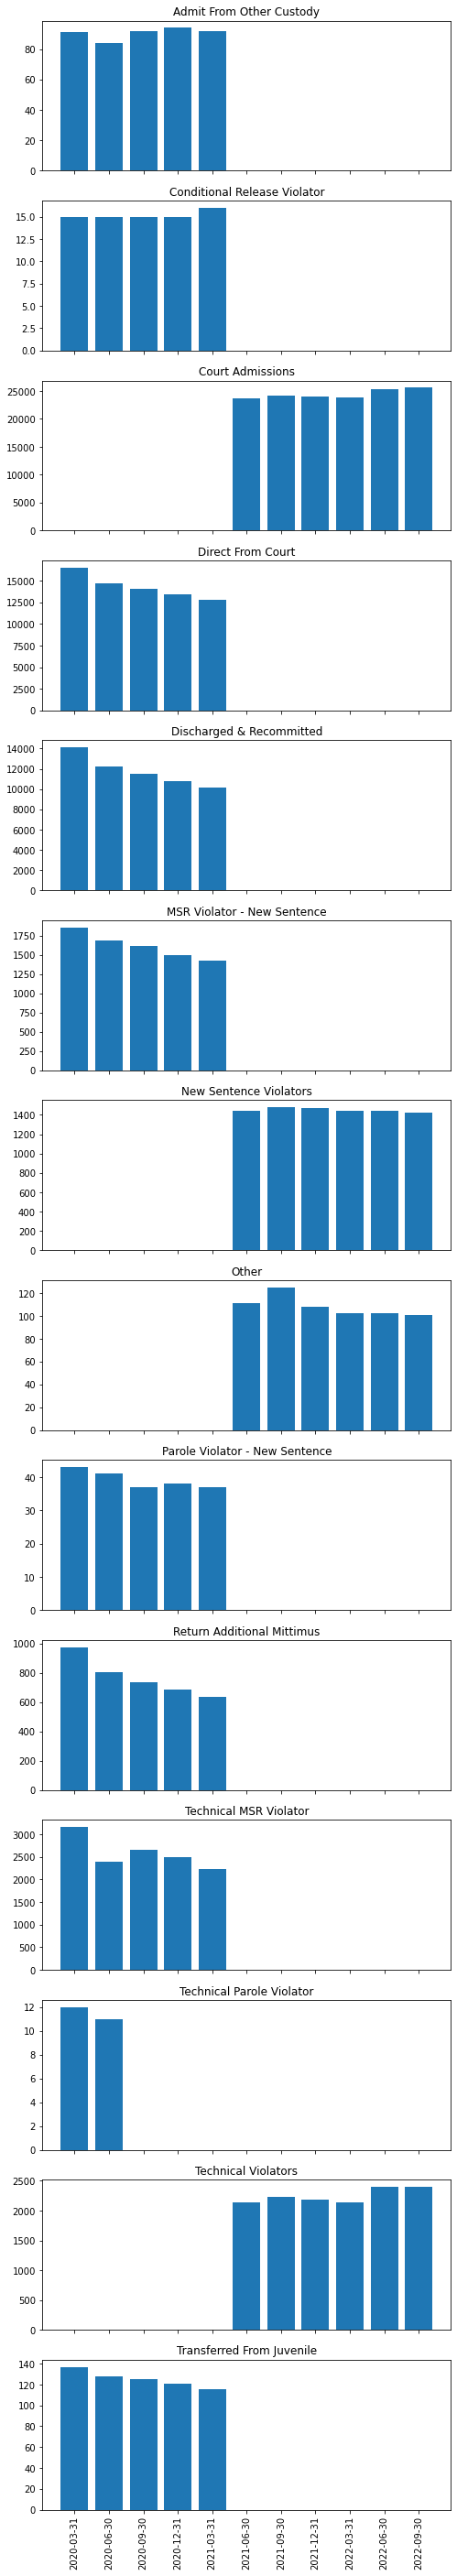

In [32]:
change_df = df[df['Doc Date'].apply(lambda x: x.date()) >= date(2020, 1, 1)]

# for recent data, plot the number of individuals with each admission type
plot_df = change_df[['Admission Type', 'Doc Date', 'IDOC #']].groupby(['Admission Type', 'Doc Date']).count().reset_index()

# keep only the admission types with significant numbers
plot_df = plot_df[plot_df['IDOC #'] > 10]

# convert dates to strings
plot_df['Doc Date'] = plot_df['Doc Date'].apply(lambda x: dt.strftime(x, '%Y-%m-%d'))

# get doc_dates for x axis
doc_dates = plot_df[['Doc Date']].drop_duplicates()

# plot bar charts for admission types each quarter
fig, axs = plt.subplots(len(plot_df['Admission Type'].unique()), figsize=(8, 50), sharex=True)#, sharey=True)
i = 0

for at in plot_df['Admission Type'].unique():
    # get the relevant df ordered by doc date
    at_df = plot_df[plot_df['Admission Type'] == at]
    at_df = pd.merge(doc_dates, at_df, on='Doc Date', how='left')
    date_order = sorted(doc_dates['Doc Date'].unique())
    at_df = at_df.set_index(at_df['Doc Date']).loc[date_order]
    
    # plot the relevant df
    axs[i].bar(at_df['Doc Date'], at_df['IDOC #'])
    axs[i].title.set_text(at)
    
    i += 1
    
plt.xticks(rotation=90)
plt.show()



For Jun 2021 going forward, IDOC used different labels.
* Before Jun 2021
    * Direct From Court
    * Admit From Other Custody
    * MSR Violator - New Sentence
    * Parole Violator - New Sentence
    * Discharged & Recommitted
    * Conditional Release Violator
    * Technical MSR Violator
    * Technical Parole Violator
    * Transferred from Juvenile
    * Return Additional Mittimus
    * COVID-19 County Admit
* Jun 2021 forward
    * Court Admissions
    * New Sentence Violators
    * Technical Violators
    * Other

In [37]:
# prep data for a sankey diagram to show the relationship between the labels in the two time periods

sankey_df = df[(df['Doc Date'].apply(lambda x: x.date()) >= date(2020, 3, 1)) & (df['Doc Date'].apply(lambda x: x.date()) <= date(2022, 9, 30))]
sankey_df = sankey_df[sankey_df['Admission Type'] != 'None']

# convert dates to strings
sankey_df['Doc Date'] = sankey_df['Doc Date'].apply(lambda x: dt.strftime(x, '%Y-%m-%d'))

# break into before and after
sankey_df = sankey_df[['IDOC #', 'Current Admission Date', 'Admission Type', 'Doc Date']].drop_duplicates()
after_df = sankey_df[sankey_df['Doc Date'].apply(lambda x: dt.strptime(x, '%Y-%m-%d').date()) >= date(2021, 6, 1)]
before_df = sankey_df[~sankey_df.index.isin(after_df.index)]

# recombine with before and after columns
after_df = after_df.drop('Doc Date', axis=1).rename(columns={'Admission Type': 'After Admission Type'})
before_df = before_df.drop('Doc Date', axis=1).rename(columns={'Admission Type': 'Before Admission Type'})
sankey_df = pd.merge(before_df, after_df, on=['IDOC #', 'Current Admission Date'], how='outer')

# drop dupes and count totals for each before/after combo
sankey_df = sankey_df.drop_duplicates()[['Before Admission Type', 'After Admission Type', 'IDOC #']].groupby(['Before Admission Type', 'After Admission Type']).count().reset_index().rename(columns={'IDOC #': 'Count'})
print(sankey_df)

# get the node df - a df dictionary of admission types and indices
node_df = pd.concat([sankey_df[['Before Admission Type']].rename(columns={'Before Admission Type': 'AT'}),
                       sankey_df[['After Admission Type']].rename(columns={'After Admission Type': 'AT'})])
node_df = node_df.drop_duplicates().reset_index(drop=True).reset_index().rename(columns={'index': 'ID'})
node_df['Color'] = get_hex(len(node_df))

# get the links df
links_df = pd.merge(sankey_df, 
                    node_df[['AT', 'ID', 'Color']].rename(columns={'ID': 'Source', 'Color': 'Link Color'}), 
                    left_on='Before Admission Type', right_on='AT', how='inner')
links_df = pd.merge(links_df, 
                    node_df[['AT', 'ID']].rename(columns={'ID': 'Target'}), 
                    left_on='After Admission Type', right_on='AT', how='inner')
links_df['Link Color'] = links_df['Link Color'].apply(lambda x: 'rgba' + str(get_rgb_from_hex(x) + (0.5,)))
links_df = links_df[['Source', 'Target', 'Link Color', 'Count']]



             Before Admission Type    After Admission Type  Count
0         Admit From Other Custody        Court Admissions      1
1         Admit From Other Custody                   Other     89
2     Conditional Release Violator                   Other     15
3                Direct From Court        Court Admissions  11844
4         Discharged & Recommitted        Court Admissions   9075
5         Discharged & Recommitted  New Sentence Violators      3
6      MSR Violator - New Sentence        Court Admissions      4
7      MSR Violator - New Sentence  New Sentence Violators   1298
8              Not In IDOC Custody                   Other      1
9   Parole Violator - New Sentence  New Sentence Violators     35
10      Return Additional Mittimus        Court Admissions    548
11      Return Additional Mittimus  New Sentence Violators      3
12               Return To Custody                   Other      1
13          Technical MSR Violator        Court Admissions      1
14        

In [38]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 20,
        thickness = 30,
        line = dict(
            color = 'black',
            width = 0
        ),
        label = node_df['AT'],
        color = node_df['Color']
    ),
    link = dict(
        source = links_df['Source'],
        target = links_df['Target'],
        value = links_df['Count'],
        color = links_df['Link Color']
    )
)])

fig.update_layout(title_text='Change in Admission Type in Jun and Dec 2021',
                  height=1000,
                  font_size=12)
fig.show()

For the most part, the new admission types group multiple old admission types.
* Court Admissions
    * Direct From Court
    * Discharged & Recommitted
    * Return Additional Mittimus
    * COVID-19 County Admit (but let's keep this as its own since its timeframe is so limited)
    * Transferred From Juvenile
* Other
    * Admit from Other Custody
    * Conditional Release Violator
    * Not In IDOC Custody
    * Return To Custody
* New Sentence Violators
    * MSR Violator - New Sentence
    * Parole Violator - New Sentence
* Technical Violators
    * Technical MSR Violator
    * Technical Parole Violator
    
Let's create a new field with the new admission types grouping the old admission types. Group others (from past quarters) based on similarity to other old admission types.


In [39]:
ct_admis_list = ['Direct From Court', 'Discharged & Recommitted', 'Return Additional Mittimus', 'Transferred From Juvenile']
other_list = ['Admit From Other Custody', 'Conditional Release Violator', 'Not In IDOC Custody', 'Return To Custody', 'Work Release Violator', 'EDV', 'Juv Parole To Adult Parole']
new_sent_viol_list = ['MSR Violator - New Sentence', 'Parole Violator - New Sentence', 'Conditional Release - New Sentence', 'Work Release Violator - New Sentence']
tech_viol_list = ['Technical MSR Violator', 'Technical Parole Violator']

df['New Admission Type'] = None
df.loc[df['Admission Type'].isin(ct_admis_list), 'New Admission Type'] = 'Court Admissions'
df.loc[df['Admission Type'].isin(other_list), 'New Admission Type'] = 'Other'
df.loc[df['Admission Type'].isin(new_sent_viol_list), 'New Admission Type'] = 'New Sentence Violators'
df.loc[df['Admission Type'].isin(tech_viol_list), 'New Admission Type'] = 'Technical Violators'

df.loc[pd.isnull(df['New Admission Type']), 'New Admission Type'] = df.loc[pd.isnull(df['New Admission Type']), 'Admission Type']

print(df['New Admission Type'].value_counts().sort_index())



Court Admissions          1438306
New Sentence Violators     138867
Other                        4734
Technical Violators        176401
Name: New Admission Type, dtype: int64


**Admission Type - Categorization**

Bucket into first-time vs. second-time vs. technical offender. 

NOTE: This is outdated and the logic cannot be used with new IDOC admission types.


In [40]:
first_list = ['DIRECT FROM COURT', 'TRANSFERRED FROM JUVENILE', 'JUV PAROLE TO ADULT PAROLE']
second_list = ['DISCHARGED & RECOMMITTED', 'MSR VIOLATOR - NEW SENTENCE', 'PAROLE VIOLATOR - NEW SENTENCE', 'WORK RELEASE VIOLATOR - NEW SENTENCE', 'CONDITIONAL RELEASE - NEW SENTENCE']
tech_list = ['TECHNICAL PAROLE VIOLATOR', 'TECHNICAL MSR VIOLATOR', 'CONDITIONAL RELEASE VIOLATOR', 'TECHNICAL VIOLATORS', 'WORK RELEASE VIOLATOR']

df['Admission Type - Recidivism'] = None
df.loc[df['Admission Type'].str.upper().isin(first_list), 'Admission Type - Recidivism'] = 'First IDOC Sentence'
df.loc[df['Admission Type'].str.upper().isin(second_list), 'Admission Type - Recidivism'] = 'Second/+ IDOC Sentence'
df.loc[df['Admission Type'].str.upper().isin(tech_list), 'Admission Type - Recidivism'] = 'Technical MSR/Parole Violator'

df.loc[pd.isnull(df['Admission Type - Recidivism']), 'Admission Type - Recidivism'] = 'Unknown/Uncategorized'

print(df['Admission Type - Recidivism'].value_counts())



Second/+ IDOC Sentence           704551
First IDOC Sentence              693451
Unknown/Uncategorized            225554
Technical MSR/Parole Violator    176846
Name: Admission Type - Recidivism, dtype: int64


**Holding offenses**

There are a lot of similar but slightly different values here. They need to be bucketed/categorized.
* Some can be bucketed based on the JHA interns' list.
* For the rest, bucket based on keywords found in the holding offense.
    * The order of operations matters. E.g. GUN --> weapon offense must come before POSS --> drug offense, since many weapons offenses include the string POSS.
* There is already a Holding Offense Category field (which is very specific), and an Offense Type field (which is broad), but neither are available before Sep 2021.

In [41]:
print(df['Holding Offense Category'].value_counts(dropna=False))
print(df['Offense Type'].value_counts(dropna=False))

len1 = len(df)

df['Holding Offense'] = df['Holding Offense'].apply(lambda x: str(x).strip())


# specific holding offenses from interns' list
inj_death_list = ['AB/NEGLECT ELD/DEATH/CAREGIVER', 'AGG BATTERY CHILD <13/GREAT BOD HARM', 'AGG BATTERY OF A CHILD', 'AGG BATTERY W/FIREARM/PERSON', 'AGG BATTERY/CHILD <13/PERM DISABL', 'AGG BATTERY/DISCHARGE FIREARM', 'AGG BATTERY/FIREARM/OFF/FIREMAN', 'AGG BATTERY/GREAT BOD HARM/60+', 'AGG BATTERY/GREAT BOD HARM/FLAME SUBST', 'AGG BATTERY/GREAT BOD HARM/PC OFF', 'AGG BATTERY/GREAT BODILY HARM', 'AGG BATTERY/HARM/PEACE OFFICER', 'AGG BATTERY/MERCHANT', 'AGG BTRY/UNLAWFUL DEL/CON SUB', 'AGG KIDNAPING/INFLICT HARM', 'AGG STALKING/BODILY HARM', 'AGG STALKING/BODILY HARM/2ND', 'AGG VEH HIJACKING/DISCH/HARM', 'AGGRAVATED BATTERY W/FIREARM', 'ARMED ROBBERY/DISCHARGE/HARM', 'DOM BTRY/BOD HARM/4+ PRI CONV', 'DOMESTIC BATTERY/BODILY HARM', 'HEINOUS BATTERY', 'HOME INVASION/CAUSE INJURY', 'HOME INVASION/DISCH FIREARM/HARM', 'INTIMIDATION/PHYSICAL HARM', 'MURDER/2ND DEGREE MURDER', 'MURDER/2ND DEGREE/PROVOCATION', 'MURDER/2ND DEGREE/UNREASON', 'MURDER/HOMICIDE/UNBORN CHILD', 'MURDER/INTENT TO KILL/INJURE', 'MURDER/OTHER FORCIBLE FELONY', 'MURDER/STRONG PROB KILL/INJURE', 'RECKLESS CONDUCT/GREAT BODILY HARM', 'VOLUN MANSL/NEGL-DEATH ANOTHER', 'DRUG INDUCED HOMICIDE', 'AGG DUI BODILY HARM/.10+/CHILD', 'AGG DUI/ACCIDENT/BODILY HARM', 'AGG DUI/ACCIDENT/DEATH', 'AGG DUI/BODILY HARM W/CHILD', 'AGG DUI/DEATH OF ANOTHER', 'AGG DUI/GREAT BODILY HARM', 'INVOL MANSLAUGHTER ATV/BOAT', 'INVOL MANSLAUGHTER FAMILY/BOAT', 'RECKLESS HOMIC/INCLINE/DEATH 2+', 'RECKLESS HOMIC/TRAFFIC CONTROL', 'RECKLESS HOMICIDE', 'RECKLESS HOMICIDE/.08 ALC/DRUG', 'RECKLESS HOMICIDE/ALC/CONVIC', 'RECKLESS HOMICIDE/ALC/DRUG', 'RECKLESS HOMICIDE/KILL 2 INDIV', 'SNOWMB OUI OF ALCOHOL/DEATH', 'INVOL MANSLAUGHTER/FAMILY MEMBER', 'INVOLUNTARY MANSLAUGHTER']
inj_death_unclear_list = ['AGG ASLT PEACE OFF/FIRE/ER WRK', 'AGG ASLT/OP MOTOR VEH/STRUCK', 'AGG ASLT/STATE IL EMP/WEAPON', 'AGG ASSAULT/CORRECTIONAL EMP', 'AGG ASSAULT/DHS EMPLOYEE', 'AGG ASSAULT/DISCH FIREARM MV', 'AGG ASSAULT/OP MOTOR VEH/PC OFF', 'AGG ASSAULT/USE FOREARM/PEACE OFF', 'AGG BATTERY SR CITIZEN >60 YRS', 'AGG BATTERY/CONTROLLED SUB', 'AGG BATTERY/GOVERNMENT EMP', 'AGG BATTERY/INGEST TOXIC SUBST', 'AGG BATTERY/JUDGE/EMT', 'AGG BATTERY/PEACE OFF/FIREMAN', 'AGG BATTERY/PEACE OFFICER', 'AGG BATTERY/PREGNANT/HANDICAPPED', 'AGG BATTERY/PUBLIC PLACE', 'AGG BATTERY/STRANGLE/PREV CONV', 'AGG BATTERY/TRANSIT EMPLOYEE', 'AGG BATTERY/USE DEADLY WEAPON', 'AGG BATTERY/WEAPON/NO FIREARM', 'AGG DISCH FIREARM/PC OFF/FIREMAN', 'AGG DISCH FIREARM/VEH/PC OFF/FRMAN', 'AGG DISCH SILENCER PERSON/VEH', 'AGG DISCHARGE FIREARM/BLDG', 'AGG DISCHARGE FIREARM/OCC BLDG', 'AGG DISCHARGE FIREARM/OCC VEH', 'AGG DOMESTIC BATTERY/STRANGLE', 'AGG INTIMIDATION PEACE OFFICER', 'AGG KIDNAPING ARMED W FIREARM', 'AGG KIDNAPING/CHILD<13/RETARDED', 'AGG KIDNAPING/CONCEAL IDENT', 'AGG ROBBERY/CONTROLLED SUB', 'AGG ROBBERY/INDICATE ARM W/FIR', 'AGG STALKING/VIO REST ORDER', 'AGG VEHICULAR HIJACKING/DISCHARGE', 'AGG VEHICULAR HIJACKING/FIREARM', 'AGG VEHICULAR HIJACKING/HANDICAPPED', 'AGG VEHICULAR HIJACKING/PASS <16 YRS', 'AGG VEHICULAR HIJACKING/WEAPON', 'AGGRAVATED ASSAULT', 'AGGRAVATED BATTERY/NURSE', 'AGGRAVATED BATTERY/STRANGLE', 'AGGRAVATED BATTERY/VICTIM 60+', 'AGGRAVATED DISCHARGE/FIREARM', 'AGGRAVATED DOMESTIC BATTERY', 'AGGRAVATED KIDNAPING/ARMED', 'AGGRAVATED KIDNAPING/RANSOM', 'AGGRAVATED ROBBERY', 'AGGRAVATED TRAFFICKING/BENEFIT', 'AGGRAVATED UNLAWFUL RESTRAINT', 'AGGRAVATED VEHICULAR HIJACKING', 'ARMED ROBBERY', 'ARMED ROBBERY/ARMED W/FIREARM', 'ARMED ROBBERY/DISCH FIREARM', 'ARMED ROBBERY/NO FIREARM', 'ARMED VIOL/CATEGORY I WEAPON', 'ARMED VIOL/CATEGORY II WEAP/1ST', 'ARMED VIOL/CATEGORY II WEAPON', 'ARMED VIOL/CATEGORY III WEAPON', 'CAUSE CHILD/ENDANGERED/2+', 'CHILD ABDUCTN/CONCEAL/DETAIN', 'COMMUNICATE/DETAIN WITNESS', 'CRIM TRES TO RES/PERS PRESENT', 'DISMEMBERING A HUMAN BODY', 'DOM BTRY/CONTACT/3 PRIOR CONV', 'DOMESTIC BATTERY/ CONTACT/PRIOR', 'DOMESTIC BATTERY/PHY CONTACT/2ND+', 'DOMESTIC BATTERY/VIOL PROTECT ORDER', 'GIVE FALSE BOMB/GAS ALARM', 'HABITUAL CRIMINAL/2 PRIOR CL X', 'HARASS JURORS/WITNESSES', 'HARASS WITNESS', 'HARASSMENT BY PHONE/4TH +', 'HOME INVASION', 'HOME INVASION/ARMED W/FIREARM', 'HOME INVASION/ARMED/FORCE', 'HOME INVASION/DANDEROUS WEAP', 'HOME INVASION/DISCH FIREARM', 'HOME INVASION/FIREARM', 'HOME INVASION/SEX OFFENSE', 'HOME INVASION/VIO AGAINST PERS', 'HRSMT/PREVENT/SERV/SAME VIC', 'HRSMT/THREATEN PERSON/KILL', 'HUMAN TRAFFICKING FOR LABOR/BENEFITS', 'INTIMIDATION/CONTEMPT/RIDICULE', 'INTIMIDATION/CRIMINAL OFFENSE', 'INVOL SERVITUDE/THREAT PHYS HARM', 'KIDNAPING ARMED WITH FIREARM', 'KIDNAPING DISCHARGE FIREARM', 'KIDNAPING W FORCE OR THREAT', 'KIDNAPING/SECRETLY CONFINE', 'PHONE HRSMT/LEWD/THREAT KILL', 'RECKLESS DISCH FIREARM/ENDANGERS', 'ROBBERY', 'ROBBERY/SCHOOL/PLACE WORSHIP', 'ROBBERY/VIC HANDICAP / 60+', 'ROBBERY/VIC HANDICAP OR 60+ YR', 'STALKING BY TRANSMITTING THREAT', 'STALKING/PERSON/SURVEILLANCE', 'STALKING/TRANSMITS THREAT/2ND', 'UNLAWFUL RESTRAINT', 'UNLAWFUL VEHICULAR INVASION', 'VEHICULAR HIJACKING', 'VIO ORDER/PRIOR VIO OF ORDER', 'VIOLATE ORDER/PRIOR DOM BATTERY', 'AB/NEGLECT ELDERLY/CAREGIVER', 'ARMED VIOL/CATEGORY II WEAP/2ND+', 'CONTEMPT', 'KIDNAPING/DECEIT OR ENTICE', 'VIOLATE STALKING NO CONTACT/2+', 'CHILD ABDUCT/LURE/VIC<17/PRIOR', 'WINDOW PEEPING 3RD+', 'ATT AGG BATTERY/CHILD <13/PERM DISABL', 'ATT AGG BATTERY/PEACE OFFICER', 'ATT AGG DISCHARGE FIREARM', 'ATT AGG DISCHARGE FIREARM AT VEH', 'ATT AGG DISCHARGE FIREARM OFFICER', 'ATT AGG VEHICLE HIJACK W WEAPON', 'ATT ARMED ROBBERY/ARMED', 'ATT ARMED ROBBERY/NO FIREARM', 'ATT DRUG-INDUCED HOMICIDE', 'ATT HOME INVASION/ARMED W/FIREARM', 'ATT HOME INVASION/FIREARM', 'ATTEMPT AGG BATTERY OF A CHILD', 'ATTEMPT AGG BATTERY/DISCHARGE FIREARM', 'ATTEMPT AGG DISCHARGE/FIREARM', 'ATTEMPT AGG KIDNAPG/CHILD<13/RETARD', 'ATTEMPT AGG KIDNAPING/INFLICT HARM', 'ATTEMPT AGG ROBBERY/INDICATE ARM W/FIR', 'ATTEMPT AGG VEHICULAR HIJACKING', 'ATTEMPT AGGRAVATED ROBBERY', 'ATTEMPT ARMED ROBBERY', 'ATTEMPT ARMED VIO/CATEGORY I WEAPON', 'ATTEMPT DISARM PC OFF/CORR EMP', 'ATTEMPT HARASS JURORS/WITNESSES', 'ATTEMPT HOME INVASION/CAUSE INJURY', 'ATTEMPT INTENT/HOMICIDE/UNBORN CHILD', 'ATTEMPT KIDNAP ARMED W FIREARM', 'ATTEMPT MURDER/INTENT TO KILL/INJURE', 'ATTEMPT MURDER/OTHER FORCIBLE FELONY', 'ATTEMPT MURDER/STRONG PROB KILL/INJURE', 'ATTEMPT ROBBERY', 'ATTEMPT ROBBERY/VIC HANDICAP OR 60+ YR', 'ATTEMPT SOLICITATION/MURDER/FOR HIRE', 'ATTEMPT VEHICULAR HIJACKING', 'CONSP AGGRAVATED ROBBERY', 'CONSP ARMED ROBBERY', 'CONSP MURDER/INTENT TO KILL/INJURE', 'SOLICIT MURDER/INTENT TO KILL/INJURE', 'SOLICITATION ROBBERY', 'SOLICITATION/MURDER', 'SOLICITATION/MURDER/FOR HIRE', 'CONSP ROBBERY', 'ATTEMPT AGG KIDNAP/CONCEAL IDENTITY', 'ATTEMPT KIDNAPING/SECRETLY CONFINE', 'CONSP AGG BATTERY/DISCHARGE FIREARM']
sex_list = ['AGG CHILD PORN/DISSEM FILM', 'AGG CHILD PORN/EXHIBIT', 'AGG CHILD PORN/LEWD EXHIBITION', 'AGG CHILD PORN/PERSON/ANIMAL', 'AGG CHILD PORN/POSS FILM/PHOTO', 'AGG CHILD PORN/POSS FILM/PREV', 'AGG CRIM SEX AB/VIC <18/FAMILY', 'AGG CRIM SEX ABUSE', 'AGG CRIM SEX ABUSE/<5 YR VIC', 'AGG CRIM SEX ABUSE/BODILY HARM', 'AGG CRIM SEX ABUSE/DURING FELONY', 'AGG CRIM SEX ABUSE/FAMILY', 'AGG CRIM SEX ABUSE/FORCE/VIC 9-13', 'AGG CRIM SEX ABUSE/INTELLIG DISABL', 'AGG CRIM SEX ABUSE/VIC <13', 'AGG CRIM SEX ABUSE/VIC 13-16', 'AGG CRIM SEX ABUSE/VIC 13-17', 'AGG CRIM SEX ABUSE/VICTIM <13', 'AGG CRIM SEX ABUSE/VICTIM <9', 'AGG CRIM SEX ASLT/INTEL DISABL', 'AGG CRIM SEX ASLT/THREAT LIFE', 'AGG CRIM SEX ASSAULT/BODILY HARM', 'AGG CRIM SEX ASSAULT/FELONY', 'AGG CRIM SEX ASSAULT/FIREARM', 'AGG CRIM SEX ASSAULT/FORCE VIC9-13', 'AGG CRIM SEX ASSAULT/HANDICAPPED', 'AGG CRIM SEX ASSAULT/RETARDED', 'AGG CRIM SEX ASSAULT/THREAT LIFE', 'AGG CRIM SEX ASSAULT/VIC 60+', 'AGG CRIM SEX ASSAULT/VICTIM <13', 'AGG CRIM SEX ASSAULT/VICTIM <9', 'AGG CRIM SEX ASSAULT/VICTIM >60', 'AGG CRIM SEX ASSAULT/WEAPON', 'AGG CRIM SEXUAL ABUSE/FELONY', 'AGG CRIM SEXUAL ASSAULT/CON SUB', 'AGG CRIM SX AB/VIC 13<18/TRUST', 'AGG CRIM SX ASLT/FORCE VIC9-13', 'AGG IND LIB/CHILD/INFLICT HARM', 'CHILD PORN/FILM/TAPE/PHOTO/ACT', 'CHILD PORN/MOVING DEPICTION', 'CHILD PORN/PERS/ANIM/MOV DPTN', 'CHILD PORN/PERSON/ANIMAL', 'CHILD PORN/POSE/EXHIBITION', 'CHILD PORN/POSS FILM/PHOTOS', 'CHILD PORN/POSS PHOTO/VIC <13', 'CHILD PORN/POSS/MOVING DPTN', 'CHILD PORN/REPRODUCE/MOV DPTN', 'CHILD PORN/REPRODUCE/SELL', 'CHILD PORN/SOL CHILD/MOV DPTN', 'CHILD PORN/SOL/CHILD/APPEAR', 'CHILD PORNOGRAPHY/VICTIM <13', 'CRIM SEX ABUSE/CANT CONSENT/2ND', 'CRIM SEX ASLT/FAM MBR <18/2+', 'CRIM SEX ASLT/FAMILY MEMBER<18', 'CRIM SEX ASLT/FORCE/PREV CONV', 'CRIM SEX ASSAULT/CANT CONSENT', 'CRIM SEX ASSAULT/CANT CONSENT/2ND', 'CRIM SEX ASSAULT/FAMILIES', 'CRIM SEX ASSAULT/FAMILIES/2ND+', 'CRIM SEX ASSAULT/FORCE', 'CRIM SEX ASSAULT/FORCE/2ND+', 'CRIM SEX ASSAULT/SUPERVN VIC 13-17', 'CRIM SEX ASSAULT/VICTIM 13-17', 'CRIM SEX ASSAULT/VICTIM 13-17/2ND', 'CRIM SEXUAL ABUSE/CONSENT', 'CRIM SEXUAL ABUSE/CONSENT/2+', 'CRIMINAL SEX ASSAULT/CONSENT', 'CRIMINAL SEXUAL ABUSE/FORCE', 'DEVIATE SEXUAL ASSAULT', 'GROOMING', 'INDECENT SOL ADULT/<13/PENETRATION', 'INDECENT SOL/AGG CRIM SEX ABUSE', 'INDECENT SOL/CRIM SEX ASSAULT', 'INDECENT SOL/PREDITORY/AGG SEX', 'NONCONSENSUAL  DISSM SEX IMAGE', 'PERMIT SEXUAL ABUSE OF CHILD', 'PRED CRIM SEX ASSLAUT/VICTIM <13', 'PREDATORY CRIM SEX ASSAULT/FIREARM', 'PREDATORY CRIM SEX ASSAULT/HARM', 'PREDATORY CRIMINAL SEXUAL ASSAULT', 'PROM JUV PROST/MINOR <13/RETAR', 'PUBLIC INDECENCY/EXPOSURE/3+', 'RAPE', 'RAPE PRIOR TO 2/1/78', 'SEX RELATIONS WITHIN FAMILIES', 'SEXUALLY DANGEROUS PERSON', 'TRAFFIC SEX SERV MINOR < 17', 'TRAVELING TO MEET A MINOR', 'UNLAWFUL VIDEO/VIC<18/SEX OFF', 'EXPLOIT CHILD/SEX ACT/2ND', 'CUSTODIAL SEXUAL MISCONDUCT', 'INDECENT SOLICIT CHILD/INTERNET', 'ATT AGG CRIM SEX ASSAULT VIC 60+', 'ATT CRIM SEX ASSAULT/FORCE', 'ATT PERMIT SEXUAL ABUSE OF CHILD', 'ATTEMPT AGG CRIM SEX ASLT/BODILY HARM', 'ATTEMPT AGG CRIM SEX ASSAULT', 'ATTEMPT AGG CRIM SEX ASSAULT/BODILY HARM', 'ATTEMPT AGG CRIM SEX ASSAULT/FELONY', 'ATTEMPT AGG CRIM SEX ASSAULT/VICTIM >60', 'ATTEMPT AGG CRIM SEX ASSAULT/WEAPON', 'ATTEMPT AGG CRIM SX AB/>5 YR OLDER VIC', 'ATTEMPT CRIM SEX ASSAULT/FORCE', 'ATTEMPT CRIM SEX ASSAULT/VICTIM 13-17', 'ATTEMPT PRED CRIM SEX ASLT/VICTIM <13', 'ATTEMPT PRED CRIMINAL SEXUAL ASSAULT', 'SOL AGG CRIM SEX ASSAULT/VIC 60+']
drugs_list = ['15<200 OBJECT/PARTS LSD/ANALOG', 'AGG DEL METH PROTECTED <5 GRAMS', 'AGG DEL METH/PROTECTED/100+ GR', 'AGG DEL METH/PROTECTED/5<15 GRAMS', 'AGG METH MANU/ORGANIZE/100<400 GR', 'AGG METH MANU/PROTECTED<15', 'AGG METH MANU/WORSHIP/<15 GR', 'AGG METH MANUF/APT/<15 GRAMS', 'AGG METH MANUF/APT/100<400 GR', 'AGG METH MANUF/CHILD 15<100 GRAMS', 'AGG METH MANUF/CHILD/<15 GRAMS', 'AGG METH MANUF/CHLD/100<400 GRAMS', 'AGG METH MANUF/CHLD/400+ GR', 'AGG METH MANUF/ORGANIZE/<15 GR', 'CALCULATED CRIM DRUG CONSP', 'CALCULATED CRIM DRUG CONSPIR', 'CANNABIS TRAFFICKING', 'CONT SUBS ACT-MANU/DEL', 'CONTROLLED SUB TRAFFICKING', 'CRIM DRUG CONSPIRACY', 'CRIMINAL DRUG CONSPIRACY', 'CRIMINAL DRUG CONSPIRACY >100 GR', 'DEL CONT SUB<18/PARK/SCHOOL/PUB HOUS', 'DEL CONT/COUNT SUB TO <18', 'DEL METH <5 GRAMS', 'DEL/NON NARC SCHED I/II/SC/HS/PARK', 'DISPOSE METH MANUF WASTE', 'MAN/DEL OTHER AMOUNT AMPHETAMINE', 'MANU 5>15 GRAMS ECSTASY', 'MANU/DEL 01-15 GRAMS COCAINE', 'MANU/DEL 1-14 GRAMS HEROIN', 'MANU/DEL 1<15 GRAM FENTANYL', 'MANU/DEL 10-15 GRAMS HEROIN', 'MANU/DEL 10<15 OBJECTS/PARTS LSD', 'MANU/DEL 10>15 PILLS ECSTASY', 'MANU/DEL 100<400 GR FENTANYL', 'MANU/DEL 100<400 GRAMS COCAINE', 'MANU/DEL 100<400 GRAMS HEROIN', 'MANU/DEL 100<400 GRAMS LSD', 'MANU/DEL 100>400 GR ECSTASY', 'MANU/DEL 15/+ GRAMS HEROIN', 'MANU/DEL 15/+GRAMS COCAINE', 'MANU/DEL 15<100 GRAMS COCAINE', 'MANU/DEL 15<100 GRAMS HEROIN', 'MANU/DEL 15<100 GRAMS LSD', 'MANU/DEL 15>100 GR ECSTASY', 'MANU/DEL 15>200 PILLS ECSTASY', 'MANU/DEL 1500+ PILLS ECSTASY', 'MANU/DEL 200+ SCHED I&II', 'MANU/DEL 200+GRAMS METH/AMPH', 'MANU/DEL 200>600 PILLS ECSTASY', 'MANU/DEL 2ND OR SUBQ OFFENSE IN ACT', 'MANU/DEL 3-15 GRAMS LSD', 'MANU/DEL 400<900 GRAMS COCAINE', 'MANU/DEL 400<900 GRAMS METH', 'MANU/DEL 50-200 GRAMS SCHED I&II', 'MANU/DEL 600<1500 OBJECTS/PARTS LSD', 'MANU/DEL 900+ GRAMS COCAINE', 'MANU/DEL 900+ GRAMS ECSTASY', 'MANU/DEL 900+ GRAMS HEROIN', 'MANU/DEL AMT NARC SCHED I/II/SCHOOL/HS/PARK', 'MANU/DEL BARB ACID/SC/PUB HOUS/PARK', 'MANU/DEL CANNABIS/>5,000 GRAMS', 'MANU/DEL CANNABIS/>500 GRAMS', 'MANU/DEL CANNABIS/10-30 GRAMS', 'MANU/DEL CANNABIS/2000<5000 GRAMS', 'MANU/DEL CANNABIS/30-500 GRAMS', 'MANU/DEL COCAINE/SCHOOL/PUB HOUS/PARK', 'MANU/DEL CONT SUBS (PRIOR 1/1/90)', 'MANU/DEL CONT SUBS/ENHANCED', 'MANU/DEL HEROIN/SCHOOL/PUB HOUS/PARK', 'MANU/DEL OTHER AMOUNT SCHEDULE III', 'MANU/DEL OTHER AMOUNT SCHEDULE IV', 'MANU/DEL OTHER AMT METH', 'MANU/DEL OTHER AMT NARC SCHED I&II', 'MANU/DEL OTHER AMT NARCOTIC SCHED I&II', 'MANU/DEL OTHER NON-NARCOTIC SCHED I&II', 'MANU/DEL SCHED I/II/SCH/HS/PARK', 'MANU/DISTRIB LOOK-ALIKE SUB', 'METH CONSP CONT SUBS >100 GR', 'METH DELIVERY/100<400 GR', 'METH DELIVERY/15<100 GRAMS', 'METH DELIVERY/400<900 GR', 'METH DELIVERY/5<15 GRAMS', 'METH DELIVERY/900+ GR', 'METH DELIVERY<5 GRAMS', 'METH MANUFACTURE/100<400 GR', 'METH MANUFACTURE<15 GRAMS', 'METH MANUFACTURING/100<400 GRAMS', 'METH MANUFACTURING/15<100 GR', 'METH MANUFACTURING/15<100 GRAMS', 'METH MANUFACTURING/400<900 GR', 'METH MANUFACTURING/400<900 GRAMS', 'METH MANUFACTURING/900+ GR', 'METH MANUFACTURING<15 GRAMS', 'METH PRECURSOR TRAFFICKING', 'METH PRECURSOR/15<30 GRAMS', 'METH PRECURSOR/500+ GRAMS', 'METH PRECURSOR<15 GRAMS', 'METHAMPHETAMINE CONSPIRACY', 'METHAMPHETAMINE TRAFFICKING', 'MFG/DEL 100<400 GR HERO/ANLG', 'MFG/DEL 15<100 GR FENTANYL', 'MFG/DEL 15<100 GR HEROIN/ANLG', 'MFG/DEL 400<900 GR HERO/ANLG', 'NARCOTICS RACKETEERING', 'OBTAIN SUBSTANCE BY FRAUD/1ST', 'POSS AMT CON SUB EXCEPT(A)/(D)', 'POSS CANNABIS/>5,000 GRAMS', 'POSS CANNABIS/10-30 GRAM/SUBQ', 'POSS CANNABIS/2,000<5,000 GRAMS', 'POSS CANNABIS/500<2,000 GRAMS', 'POSS CONT SUBS', 'POSS HYPO/SYRINGE/NEEDLES/2ND+', 'POSS METH MANUF MATERIAL', 'POSS OF METH < 5 GRAMS', 'POSS OF METH/ 15<100 GRAMS', 'POSSESS 100<400 GRAMS COCAINE', 'POSSESS 100<400 GRAMS HEROIN', 'POSSESS 15+ GRAMS COCAINE', 'POSSESS 15+ GRAMS HEROIN', 'POSSESS 15+ GRAMS MORPHINE', 'POSSESS 15<100 GRAMS COCAINE', 'POSSESS 15<100 GRAMS HEROIN', 'POSSESS 15<100 GRAMS METH', 'POSSESS 15<200 OBJECT/PART LSD', 'POSSESS 15>200 PILLS ECSTASY', 'POSSESS 1500+ PILLS ECSTASY/ANALOG', 'POSSESS 200+ GRAMS OTHER SCHED I&II', 'POSSESS 400<900 GRAMS COCAINE', 'POSSESS 400<900 GRAMS HEROIN', 'POSSESS 900 + GRAMS COCAINE', 'POSSESS 900 + GRAMS HEROIN', 'POSSESSION OF METH/100<400 GRAMS', 'POSSESSION OF METH/15<100 GRAMS', 'POSSESSION OF METH/400<900 GR', 'POSSESSION OF METH/5<15 GRA', 'POSSESSION OF METH/900+ GR', 'POSSESSION OF METH< 5 GRAMS', 'PRODUCE >200 CANNABIS PLANTS', 'TAMPER W/ANHYD AMM EQUIPMENT', 'USE OF DANGEROUS PLACE/CON SUB', 'USE VEH/STRUCTURE/PROP/METH', 'POSS BLANK COUNTERFEIT SCRIPT', 'POSS CANNABIS/30-500 GRAM/1ST', 'MANU/DEL CONT SUBS', 'MANU/DEL 10<30 GRAMS KETAMINE', 'POSS 400>900 GR ECSTASY/ANALOG', 'PRODUCE 5-20 CANNABIS PLANTS', 'ATT MANU 200>600 PILLS ECSTASY', 'ATT METH PRECURSOR/30<150 GR', 'ATTEMPT MANU/DEL 15/+GRAMS COCAINE', 'ATTEMPT MANU/DEL CANNABIS/>500 GRAMS', 'ATTEMPT MANU/DEL OTHER AMT NARC', 'ATTEMPT POSS METH MANUF MATERIAL', 'ATTEMPT POSSESS 15<100 GRAMS COCAINE', 'CONSP MANU/DEL 01-15 GRAMS COCAINE', 'CONSP MANU/DEL OTHER AMOUNT METH', 'CONSP MFG/DEL CANNABIS/>5,000 GRAMS', 'SOLICIT MANU/DEL 01-15 GRAMS COCAINE', 'ATTEMPT MANU/DEL 01-15 GRAMS COCAINE', 'CONSPIRACY METH MANUFACTURE<15 GRAMS', 'ATTEMPT POSS AMT CON SUB', 'CONSP MANU/DEL 15/+GRAMS COCAINE']
property_list = ['AGG ARSON', 'AGG ARSON/INJURE FIRE/POLICE', 'AGG ARSON/KNOW PEOPLE PRESENT', 'AGG HOME FRAUD VIC >60 >%500', 'AGG ID THEFT/<$300/DISABLED', 'AGG ID THEFT/$10,000-$100,000/60 YRS+', 'AGG ID THEFT/$300-10,000/60 YRS +', 'AGG ID THEFT/AGE 60+/2+', 'AGG ID THFT/10K-100K/GANG ACTS', 'AGG ID THFT/ID STOLEN/VIC 60+', 'AGG INSURANCE FRAUD', 'AGGRAVATED ARSON', 'AGGRAVATED ARSON/BODILY HARM', 'AID/ABET/POSS/SELL STOLEN VEH', 'ARSON', 'ARSON/REAL/PERSONAL PROP>$1', 'BAD CHK/OBTAIN CON PROP/>150', 'BURGLARY', 'BURGLARY W/O CAUSING DAMAGE', 'BURGLARY/SCHOOL/PLACE WORSHIP', 'CAUSING A CATASTROPHE', 'CONTINUING FINANCE CRIME ENTRPRS', 'COUNTERFEIT CREDIT/DEBIT CARD', 'CRIM DMG TO PROP $300-10000', 'CRIMINAL DAMAGE $10000-$100000', 'DEFRAUD FINANC INST/$500-$10,000', 'DEFRAUD FINANCIAL INST/>$100K', 'FIN EXPLOIT ELDERLY/70+/$15K+', 'FINANCE EXPLOIT ELD/DISABL/$300-$5,000', 'FINANCIAL INSTITUTION ROBBERY', 'FORGERY /MAKE OR ALTER DOCUMENT', 'FORGERY/ISSUE DOCUMENT/1 UPC', 'FORGERY/ISSUE/DELIVER DOCUMENT', 'FORGERY/POSSESS W INTENT', 'ID THEFT/OBTAIN/3+ INDIV', 'ID THFT/OBTAIN INFO/COMMIT FEL', 'IDENTITY THEFT >$100,000', 'IDENTITY THEFT/<$300', 'IDENTITY THEFT/$10K - $100K', 'IDENTITY THEFT/$2000-$10,000', 'IDENTITY THEFT/$300-$2000', 'IDENTITY THEFT/KNOWS ID STOLEN', 'KNOW ID STOLEN/MILITARY VIC/2+', 'MOB ACTION', 'ORGANIZE/AGG VEH THEFT CONSPIR', 'ORGANIZER/FIN CRIME ENTRPRS', 'POSS STOLEN VEHICLE > $25,000', 'POSSESS BURGLARY TOOLS', 'RECEIVE/POSS/SELL STOLEN VEH', 'RECEIVE/POSS/SELL STOLEN VEHICLE', 'RESIDENTIAL ARSON', 'RESIDENTIAL BURGLARY', 'RET THEFT/DISP MERCH/<$300/PREV CONV', 'RET THEFT/DISP MERCH/>$300', 'RETAIL THEFT/DISP MERCH/<$150/2+', 'RETAIL THEFT/EMERGENCY EXIT/>$300', 'RETAIL THEFT/MOTOR FUEL/>$150', 'THEFT', 'THEFT <$300', 'THEFT <$300 PRIOR', 'THEFT <$300 WITH PRIOR', 'THEFT <$300/PRIOR CONVICT', 'THEFT <$300/SCHOOL/WORSHIP', 'THEFT >$10,000 <$100,000', 'THEFT >$10,000-$100,000', 'THEFT >$100,000-$500,000', 'THEFT >$100,000/SCHOOL/WORSHIP', 'THEFT >$300-$10,000', 'THEFT $300-$10,000/SCHOOL/WORSHIP', 'THEFT $300<$10,000', 'THEFT CONTROL INTENT <$500 PRIOR', 'THEFT CONTROL INTENT $500<$10,000', 'THEFT CONTROL INTENT 10K<100K', 'THEFT CONTROL OF PROPERTY <$500', 'THEFT DECEP INTENT $10,000<$100,000', 'THEFT DECEPTION INTENT 300<10,000', 'THEFT DECEPTION INTENT 500<10000', 'THEFT STOLEN <$300 PRIOR', 'THEFT STOLEN INTENT PERS <$300', 'THEFT STOLEN/>$300 <$10,000', 'THEFT/COIN OP MACHINE/2ND+', 'THEFT/CONTROL INTENT>$500K-1M', 'THEFT/CONTROL/INTENT >$1M', 'THEFT/DECEPTION > $100,000', 'THEFT/DECEPTION >$500,000', 'THEFT/DECEPTION/<$500 PRIOR', 'THEFT/DECEPTION/>$500 <10K', 'THEFT/EMER EXIT/<$300/PRECONV', 'THEFT/STOLEN/ <$500 PRIOR CONV', 'THEFT/STOLEN/>$10,000 <$100,000', 'THEFT/UNAUTHD CONTROL>$300<10000', 'THFT/SWITCH PRICE/<300/PRECONV', 'UNLAWFUL POSS CREDIT/DEBIT CARD', 'UNLAWFUL POSS/DRIVER/VEH/STOLEN', 'UNLAWFUL POSS>3VEH/PARTS/STOLEN', 'USE FORGED CREDIT/DEBIT CARD/>$300', 'VEHICLE THEFT CONSPIRACY', 'FORGE REGISTRATION, ETC', 'ID THEFT/USE ID/COMMIT FELONY', 'IDENTITY THEFT $2,000<$10,000', 'THEFT/FALSE REP/<$300/PRECONV', 'USE OF ACCT NUMBER/CODE/>$150', 'AID/ABET CONCEAL/MISREP VEHICLE', 'RETAIL THEFT/EMERGENCY EXIT/<$300', 'HOME REPAIR FRAUD/CONTRACT >$1,000', 'THFT/LES RTN PROP/<300/PRECONV', 'USE OF ACCT NUMBER/CODE/<$150', 'CRIM DAMAGE PROP>$100,000', 'RET THEFT/MOTOR FUEL/<$150/PREV CONV', 'UNLAWFUL USE ID CARD/THEFT', 'ATT RECEIVE/POSS/SELL STOLEN VEH', 'ATTEMPT AGG ARSON', 'ATTEMPT ARSON', 'ATTEMPT ARSON >$150', 'ATTEMPT BURGLARY', 'ATTEMPT BURGLARY/SCHOOL/PLACE WORSHIP', 'ATTEMPT POSS STOLEN TITLE/CERTIF/PLATE', 'ATTEMPT POSS STOLEN VEHICLE > $25,000', 'ATTEMPT RESIDENTIAL ARSON', 'ATTEMPT RESIDENTIAL BURGLARY', 'ATTEMPT THEFT >$10,000-$100,000', 'CONSP RESIDENTIAL BURGLARY', 'ATTEMPT AID/ABET CONCEAL/MISREP VEHICLE']
weapon_list = ['AGG POSS/11-20 STOLEN FIREARMS', 'AGG POSS/2-5 STOLEN FIREARMS', 'AGG UNLAWFUL USE OF WEAPON/VEH', 'AGG UNLAWFUL USE WEAPON/VEH/2ND', 'AGG UUW/ON PERSON', 'AGG UUW/PERS/FIR LOADED/FOID', 'AGG UUW/PERSON/PREV CONVICTION', 'AGG UUW/VEH/PREV CONVICTION', 'ARMED HABITUAL CRIMINAL', 'FIREARM/AMMO ACT-POSS WO/ID CARD', 'FIREARM/FOID INVALID/NO ELIG', 'GUNRUNNING', 'POSS EXPLOSIVE/INCENDIARY DEVICE', 'POSS FIREARM W/ DEFACED SER NO', 'POSS FIREARM/FOID NO ISSUE/NO ELIG', 'POSS FIREARM/LAND/GANG MEMBER', 'POSS OF FIREARM BY GANG MEMBER', 'POSSESSION OF STOLEN FIREARM', 'UNLAWFUL POSS HANDGUN/DEL/<21', 'UUW-FELON POSS WEAPON/BODY ARMOR', 'UUW-FELON POSS/USE FIREARM PRIOR', 'UUW-FELON POSS/USE FIREARM/PAROLE', 'UUW-FELON POSS/USE WEAPON/FIREARM', 'UUW/CARRY/POSS FIREARM/SCHOOL', 'UUW/MACHINE GUN/AUTO WEAPON/VEH', 'UUW/RIFLE <16 IN/SHOTGUN <18', 'UUW/CARRY/POSS FIREARM/2ND+', 'AGG UUW/PERSON/LOADED FIREARM/2+', 'UUW/CARRY/POSS FIREARM/1ST', 'ATT AGG POSS/31+ STOLEN FIREARMS', 'ATT FELON POSS/USE WEAP/BODY ARMOR', 'ATTEMPT AGG UUW W/ BODY ARMOR/PRIVATE', 'ATTEMPT UUW/FELON POSS/USE FIREARM/PAROLE', 'ATT POSS FIREARM/VEHICLE/GANG MEMBER', 'ATTEMPT POSSESSION OF STOLEN FIREARM']
vehicle_list = ['AGG DUI', 'AGG DUI - SCHOOL BUS DRIVER', 'AGG DUI / 5TH DUI', 'AGG DUI / NO VALID INSURANCE', 'AGG DUI LIC SUSP OR REVOKED', 'AGG DUI/ 4TH /BAC 0.16+', 'AGG DUI/3', 'AGG DUI/3/BAC .16+', 'AGG DUI/3/PASS <16', 'AGG DUI/3RD/LIC SUSP OR REV', 'AGG DUI/3RD+', 'AGG DUI/4', 'AGG DUI/4TH/LIC SUSP OR REVOKED', 'AGG DUI/5/BAC 0.16>', 'AGG DUI/6+', 'AGG DUI/6+/BAC 0.16+', 'AGG DUI/DO DRIVER LICENSE', 'AGG DUI/LIC SUSP OR REVOKED', 'AGG DUI/NO VALID DL', 'AGG DUI/NO VALID INS', 'AGGRAVATED DUI/3RD+ DUI', 'DUI/3RD/BAC 0.16+', 'DUI/4TH+/LIC SUSP OR REVOKE', 'DUI/6TH', 'AGG DUI NO VALID DRIVERS LICENSE', 'AGG DUI/3RD+ DUI', 'DRIV LIC REVOKED/RECK HOMIC/2', 'DRIVE REVOKED/RECK HOMIC', 'DRIVE REVOKED/RECKL HOMIC/3', 'DRIVE W REVOKED/RECK HOMIC/4+', 'DRIVING RVK/SUSP DUI/SSS 4-9', 'DRIVING W/ REVOKE/SUSPEND LICENSE 2ND+', 'DRIVING W/ SUSPEND/REVOKE LICENSE 10-14', 'DRIVING W/ SUSPEND/REVOKE LICENSE 15+', 'DRIVING W/ SUSPEND/REVOKE LICENSE 2ND', 'DRIVING W/ SUSPEND/REVOKE LICENSE 3RD', 'DRIVING W/ SUSPEND/REVOKE LICENSE 4-9', 'REVOKED/SUSPENDED 2ND DUI']
registry_list = ['VIOLENT OFF/YOUTH FAIL REGIS NEW RESID/SCHOOL', 'VIOLENT OFF/YOUTH FAIL REGIS/FAIL TO REPORT', 'VIOLENT OFF/YOUTH FAIL REGISTER IN ILLINOIS', 'VIOLENT OFF/YOUTH FAIL REGIS IN ILLINOIS 2+', 'CHIL SEX OFFEN/RESIDE SAY CARE', 'CHILD SEX OFFENDER/PUBLIC PARK', 'CHILD SEX OFFENDER/RESIDE 500FT', 'FAIL REGIS/NEW REDIS/SCH/2ND+', 'FAIL TO REPORT ANNUALLY/2+', 'SEX OFF FAIL REGISTER NEW RESIDENCE', 'SEX OFF FAIL REPORT CHANGE ADDR/EMPL', 'SEX OFF FAIL REPORT CHANGE ADDRESS/EMPLOY', 'SEX OFF FAIL TO REPORT ANNUALLY', 'SEX OFF FAIL TO REPORT WEEKLY/2ND', 'SEX OFFENDER AT PUBLIC PARK', 'SEX OFFENDER GIVE FALSE INFO/2ND', 'SEX OFFENDER REGIS VIOLATION', 'SEX OFFENDER REGIS/FALSE INFO', 'SEX VIOL/DANGEROUS FAIL TO RPT', 'PHOTO/DIGITAL IMAGE OF CHILD BY SEX OFFENDER', 'ATT SEX OFF FAIL REPORT/NO ADDR/2', 'ATT VIOL SEX OFFENDER REGIS ACT']
other_list = ['AGG FLEEING POLICE/21 MPH OVER', 'AGG FLEEING POLICE/2ND', 'AGG FLEEING/2+ CON DVC/2ND', 'AGG FLEEING/2+ DISOBEY TRAFFIC DEVICES', 'AGG FLEEING/21 MPH OVER/2ND', 'AGG FLEEING/DAMAGE >$300 PROPERTY', 'BRIBERY/OFFER BRIBE', 'BRING CANNABIS IN A PENAL INST', 'BRING CON SUBSTANCE PENAL INST', 'BRING TOOL IN A PENAL INSTITUTION', 'BRING/POSS CONTRAB IN PENAL INST', 'CAUSE/BRG CON SUB PENAL INST', 'CONCEAL HOMICIDAL DEATH', 'CONCEAL/AID FUGITIVE', 'CONSP AGAINST CIVIL RIGHTS', 'DISARM PC OFF/CORR INST EMP', 'DISARMING A PEACE OFFICER', 'ESCAPE FROM DEPT OF CORRECTION', 'ESCAPE OF FELON FROM PENAL INST', 'ESCAPE/VIOLATE ELEC MONITORING', 'FAIL REPORT ACCIDENT/DEATH/INJURY', 'FAILURE REPORT ACCIDENT/DEATH', 'FAILURE REPORT ACCIDENT/INJURY', 'FALSE ALARM/COMPLAINT TO 911', 'FALSE PERSONATION OF POLICE', 'FALSE REPORT OF OFFENSE', 'FELON ESCAPE/PEACE OFFICER', 'FELON FAIL TO RETURN FROM FURLOUGH', 'FELON PROBATIONER ESCAPE OFF', 'FLEEING/ATTEMPT ELUDE OFF 3+', 'INDIRECT CRIMINAL CONTEMPT', 'MANUF/POSS ADULTERANTS DRUG TEST', 'MONEY LAUNDERING >$500,000', 'OBSTRUCT JUST/DESTROY EVIDENCE', 'OBSTRUCTING JUSTICE', 'POSS CONTROL SUBST PENAL INST', 'POSS CONTROL SUBSTANCE IN PENAL INST', 'POSS FRAUDULENT ID CARD', 'POSS/FRAUD/DL/PERMIT', 'POSSESS CANNIBIS PENAL INST', 'POSSESS ELEC CONTRABAND PENAL INST', 'POSSESS WEAPON IN PENAL INST', 'RESIST/OBSTRUC OFFICER/INJURY', 'RICO ACQUIRE ENTERPRISE', 'RICO CONSPIRACY TO VIOLATE', 'TERRORISM/FALSE THREAT', 'THREATEN PUBLIC OFFICIAL', 'THREATEN PUBLIC OFFICIAL/2ND', 'UUW-FELON POSS WEAPON IN PRISON', 'VENDOR FRAUD/KICKBACKS VIOL', 'CRIM DAMAGE/GOVT PROP/EXPL/<$500', 'CRIM DMG/GOVT PROP/<$500', 'CRIM DMG/GOVT PROP/>$500-$10K', 'RESIST/OBSTRUCT OFFICER/INJURY', 'UUW-FELON POSS/USE WEAP/PRISON', 'CRIM DAMAGE/STATE PROP/FIRE>$100,000', 'POSS/DISP ID CARD TO ANOTHER', 'ATT FOIL/DEFEAT SCREEN TEST', 'ATTEMPT ESCAPE FELON FROM PENAL INST', 'AGGRAVATED CRUELTY TO ANIMALS', 'ANIMAL TORTURE/2ND', 'CRUELTY TO ANIMALS/2ND', 'DOG FIGHTING/ATTEND SHOW']

df.loc[df['Holding Offense'].isin(inj_death_list), 'Holding Offense Cat'] = 'Person - Death/Physical Injury'
df.loc[df['Holding Offense'].isin(inj_death_unclear_list), 'Holding Offense Cat'] = 'Person - Death/Physical Injury Unclear'
df.loc[df['Holding Offense'].isin(sex_list), 'Holding Offense Cat'] = 'Sex'
df.loc[df['Holding Offense'].isin(drugs_list), 'Holding Offense Cat'] = 'Drugs'
df.loc[df['Holding Offense'].isin(property_list), 'Holding Offense Cat'] = 'Property'
df.loc[df['Holding Offense'].isin(weapon_list), 'Holding Offense Cat'] = 'Firearms/Weapon'
df.loc[df['Holding Offense'].isin(vehicle_list), 'Holding Offense Cat'] = 'DUI/Vehicle Violation Without Death/Physical Injury'
df.loc[df['Holding Offense'].isin(registry_list), 'Holding Offense Cat'] = 'Sex Offender/MVOAY Registry Violation'
df.loc[df['Holding Offense'].isin(other_list), 'Holding Offense Cat'] = 'State/Other'


# categorize unlisted offenses based on "like" criteria
# ----- these won't be 100% accurately categorized, but it should be close -----
offense_cat_dict = {'SEX OFF': 'Sex Offender/MVOAY Registry Violation',
                    'SEX': 'Sex',
                    'INDEC': 'Sex',
                    'MURDER': 'Person - Death/Physical Injury',
                    'HOMIC': 'Person - Death/Physical Injury',
                    'HARM': 'Person - Death/Physical Injury',
                    'PORN': 'Sex',
                    'DUI': 'DUI/Vehicle Violation Without Death/Physical Injury',
                    'ASSAULT': 'Person - Death/Physical Injury Unclear',
                    'BATTERY': 'Person - Death/Physical Injury Unclear',
                    'DISCH': 'Firearms/Weapon',
                    'FIREA': 'Firearms/Weapon',
                    'THEFT': 'Property',
                    'STOLE': 'Property',
                    'METH': 'Drugs',
                    'KINAP': 'Person - Death/Physical Injury Unclear',
                    'ROBB': 'Property',
                    'WEAP': 'Firearms/Weapon',
                    'GUN': 'Firearms/Weapon',
                    'POSS': 'Drugs',   # this one especially contains non-drug offenses
                    'ARSON': 'Property',
                    'ABD': 'Person - Death/Physical Injury Unclear',
                    'DEL': 'Drugs',
                    'MANS': 'Person - Death/Physical Injury',
                    'MAN': 'Drugs',
                    'ENDANGER': 'Person - Death/Physical Injury Unclear',
                    'CANNA': 'Drugs',
                    'PROP': 'Property',
                    'DRUG': 'Drugs'
                    }

# for each key word, label all holding offenses that contain that key word
for key, val in offense_cat_dict.items():    
    df.loc[(df['Holding Offense'].str.contains(key)) & (pd.isnull(df['Holding Offense Cat'])), 'Holding Offense Cat'] = val

    
# label those that are still uncategorized as other
df.loc[pd.isnull(df['Holding Offense Cat']), 'Holding Offense Cat'] = 'State/Other'


if len(df) != len1:
    print('ERROR: categorizing offenses changed the df length')
    1/0
    
print(df['Holding Offense Cat'].value_counts(dropna=False))



NaN                             1658133
Homicide                          38803
Sex Assault After 7-84            21069
Assault-Battery-Force-Harm        16211
Weapons                           14828
Control Substance Viol            13516
Armed Robbery                      8293
Burglary                           3673
Residential Burglary               3590
Other Sex Offenses                 3220
DUI-Liquor                         3161
Robbery                            3012
Motor Veh Theft                    1758
Kidnapping                         1503
Home-Veh Invasion                  1455
Theft                               998
Armed Violence                      948
Escape or Aid                       899
Motor Veh Offenses                  849
Retail Theft                        799
SDP                                 751
Arson                               688
Forgery-Deception-Fraud             659
Govt-Bribery-Business               465
Cannabis                            443


In [42]:
# prep for sankey diagram
holding_sankey_df = df[['Holding Offense Cat', 'Offense Type', 'IDOC #', 'Current Admission Date']].drop_duplicates()
holding_sankey_df = holding_sankey_df[['Holding Offense Cat', 'Offense Type', 'IDOC #']].groupby(['Holding Offense Cat', 'Offense Type']).count().reset_index().rename(columns={'IDOC #': 'Count'})
print(holding_sankey_df)

# get the node df - a df dictionary of admission types and indices
node_df = pd.concat([holding_sankey_df[['Holding Offense Cat']].rename(columns={'Holding Offense Cat': 'AT'}),
                       holding_sankey_df[['Offense Type']].rename(columns={'Offense Type': 'AT'})])
node_df = node_df.drop_duplicates().reset_index(drop=True).reset_index().rename(columns={'index': 'ID'})
node_df['Color'] = get_hex(len(node_df))

# get the links df
links_df = pd.merge(holding_sankey_df, 
                    node_df[['AT', 'ID', 'Color']].rename(columns={'ID': 'Source', 'Color': 'Link Color'}), 
                    left_on='Holding Offense Cat', right_on='AT', how='inner')
links_df = pd.merge(links_df, 
                    node_df[['AT', 'ID']].rename(columns={'ID': 'Target'}), 
                    left_on='Offense Type', right_on='AT', how='inner')
links_df['Link Color'] = links_df['Link Color'].apply(lambda x: 'rgba' + str(get_rgb_from_hex(x) + (0.5,)))
links_df = links_df[['Source', 'Target', 'Link Color', 'Count']]

# create the chart
fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 20,
        thickness = 30,
        line = dict(
            color = 'black',
            width = 0
        ),
        label = node_df['AT'],
        color = node_df['Color']
    ),
    link = dict(
        source = links_df['Source'],
        target = links_df['Target'],
        value = links_df['Count'],
        color = links_df['Link Color']
    )
)])

fig.update_layout(title_text="Difference between Phil's Categories and IDOC Offense Type", 
                  height=1000, 
                  font_size=12)
fig.show()
                                                                                                  


                                  Holding Offense Cat     Offense Type  Count
0   DUI/Vehicle Violation Without Death/Physical I...      Drug Crimes    839
1   DUI/Vehicle Violation Without Death/Physical I...  Property Crimes    374
2                                               Drugs      Drug Crimes   5509
3                                               Drugs     Other Crimes      1
4                                               Drugs    Person Crimes      3
5                                               Drugs  Property Crimes     17
6                                     Firearms/Weapon     Other Crimes      2
7                                     Firearms/Weapon    Person Crimes   5168
8                                     Firearms/Weapon  Property Crimes      3
9                      Person - Death/Physical Injury      Drug Crimes    195
10                     Person - Death/Physical Injury    Person Crimes   9614
11                     Person - Death/Physical Injury  Property 

Phil's categories match pretty well with IDOC's.

**Recidivism calculation**

IDOC changed the way that it records recidivism over the years. Recalculate recidivism as sentence number.

In [43]:
# convert admission date to a datetime
df['Current Admission Date'] = pd.to_datetime(df['Current Admission Date'])

len1 = len(df)

# rank the admission date per person - this is the nth time they've been admitted
df_admis_rank = df[['IDOC #', 'Current Admission Date']].drop_duplicates()
df_admis_rank['Sentence Number'] = df_admis_rank.groupby(['IDOC #'])['Current Admission Date'].rank(ascending=True)

# join back to the full dataframe
df = pd.merge(df, df_admis_rank, on=['IDOC #', 'Current Admission Date'], how='inner')

if len(df) != len1:
    print('ERROR: Adding the sentence number changed the df length')



**Eligibility for Sentencing Credits**

For the purposes of our analysis, someone is *ineligible* for earned discretionary sentencing credits (EDSC) if:
* Their holding offense is related to gunrunning or sex
* They're sentenced to life
* They're required to serve at least 85% of their sentence under truth-in-sentencing
* They're considered a sexually dangerous person (SDP)

Otherwise, they are eligible.

In [44]:
df['EDSC Eligible'] = None
df.loc[(((df['TIS Pct'] >= 0.85) & (~pd.isnull(df['TIS Pct'])))
      | (df['Holding Offense'].str.contains('GUNRUNNING'))
      | (df['Sentence Years'].isin(['LIFE', 'SDP']))
      | (df['Holding Offense Cat'] == 'Sex')),
      'EDSC Eligible'] = 'N'

df.loc[pd.isnull(df['EDSC Eligible']), 'EDSC Eligible'] = 'Y'

print(df['EDSC Eligible'].value_counts())



Y    1171131
N     629271
Name: EDSC Eligible, dtype: int64


**Exporting the data**

The full data set is 1.8 million records. Export with understanding.

In [45]:
print(len(df))

1800402


In [ ]:
# export more recent data
# df_recent = df[df['Doc Date'] >= date(2014, 1, 1)]
# print(len(df_recent))
# df_recent.to_csv('pop_data_2014_thru_20220331.csv')

# # export single institution all time
# df_export = df[df['Parent Institution'] == 'Logan']
# print(len(df_export))


In [46]:
# df_recent.to_csv('pop_data_20140101-20211231.csv')
df.to_csv('pop_data_thru_20220930.csv')

In [ ]:
tmp_df = df[(df['Doc Date'].apply(lambda x: x.date()) >= date(2022, 2, 1))] #& (df['Doc Date'] <= date(2018, 9, 30))]
print(len(tmp_df))

In [ ]:
tmp_df.to_csv('tmp_df.csv')